Contributors:
1. Ilyas Al-Rai: 10031454
2. Mahmoud Almurish: 10035422
3. Ahmed Mahjoub: 10024654


todos:
1. introduction
2. Data Loading and Preprocessing
3. DCGAN Architecture
4. Training
5. Model Evaluation

In [2]:
# torch import
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F






C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: htt

In [3]:
# matplotlib import
from matplotlib import pyplot as plt
import PIL

In [4]:
# other imports
from tqdm import tqdm
import torch.optim as optim


In [5]:
def show_image(img, label="image"):
    if (not isinstance(img, PIL.Image.Image)):
        img = F.to_pil_image(img)

    _, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Display original image and mask
    axes.imshow(img)
    axes.set_title(label)
    axes.axis('off')

In [6]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((.5, ), (0.5,)),
    ]
)
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [7]:
dataset = torchvision.datasets.FashionMNIST('./dataset', download=True, transform=transform)

In [8]:
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27288\656562870.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1, 1, figsize=(10, 5))


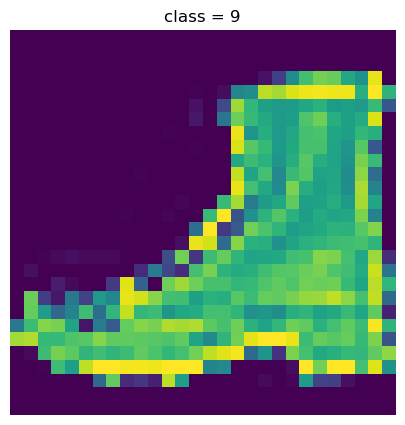

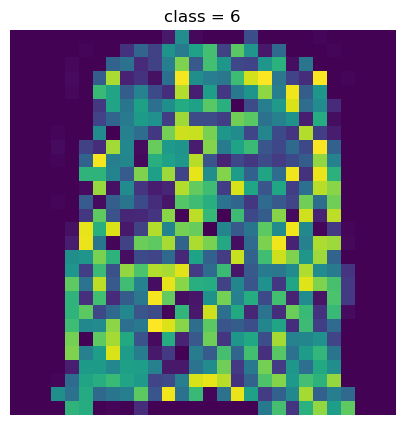

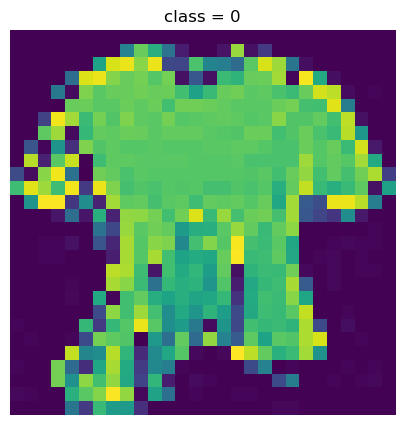

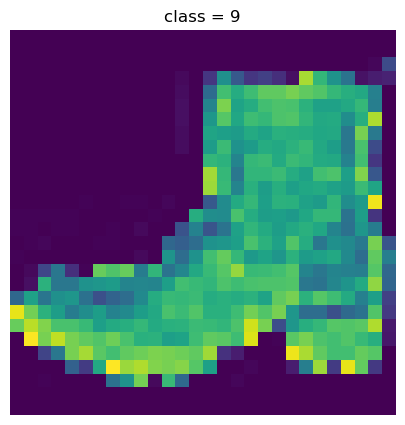

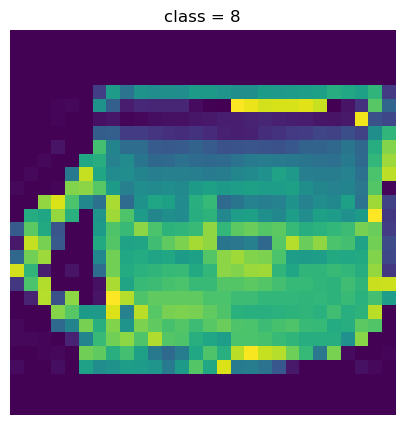

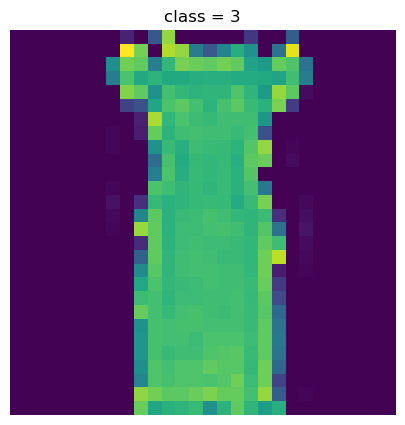

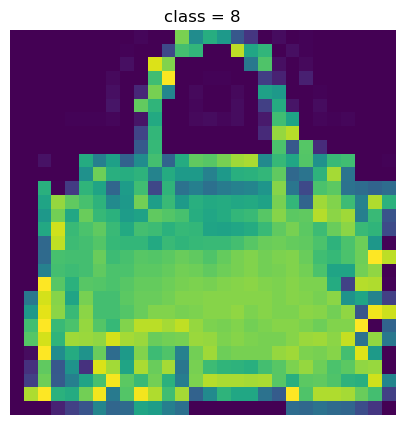

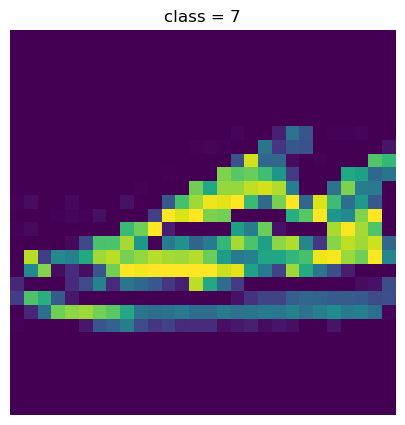

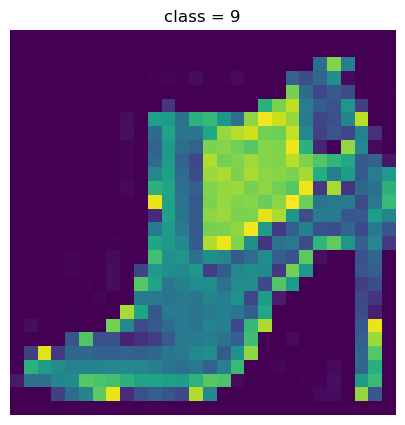

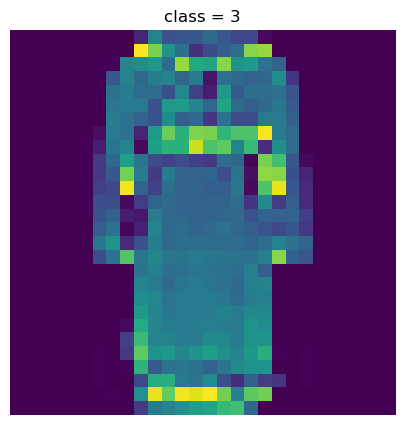

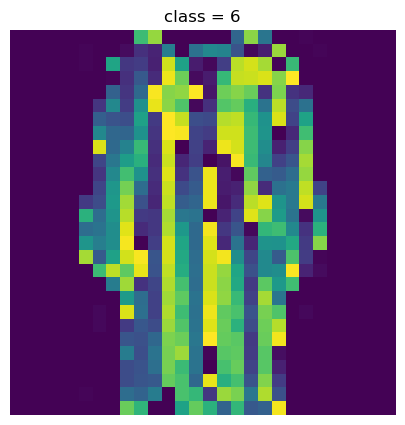

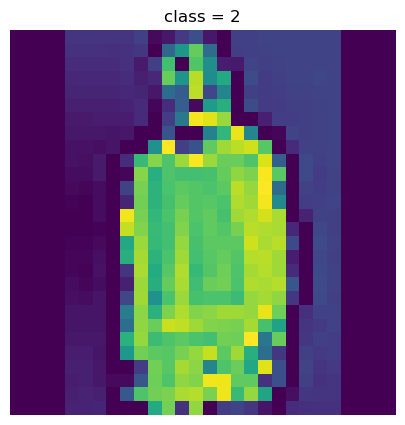

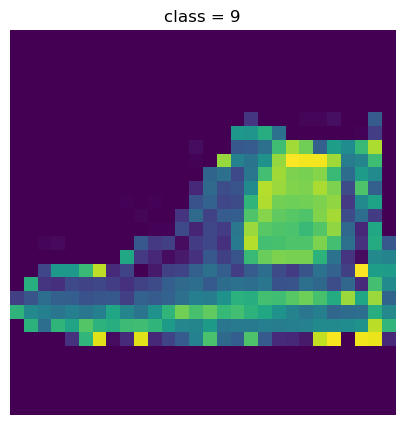

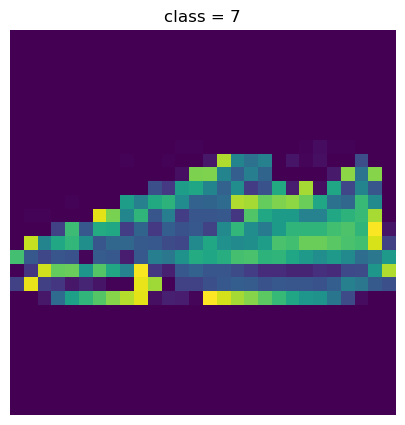

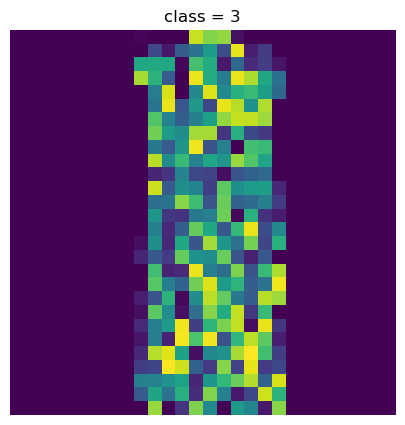

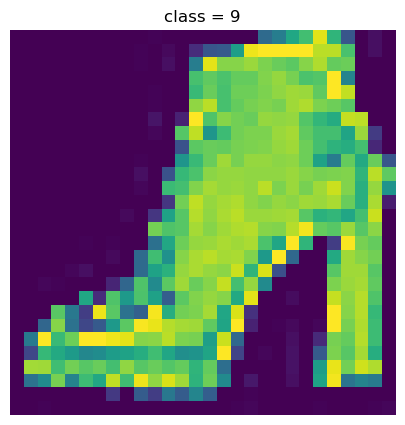

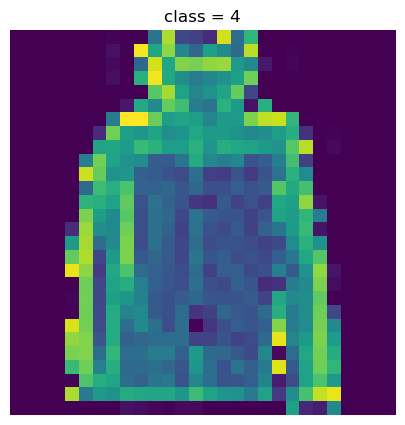

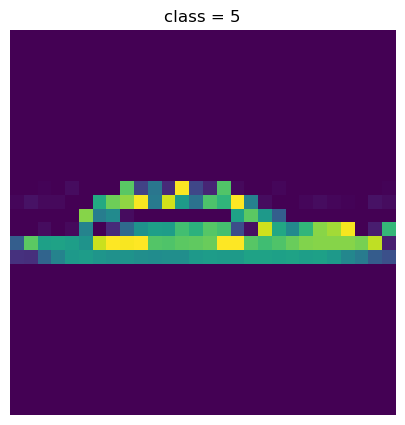

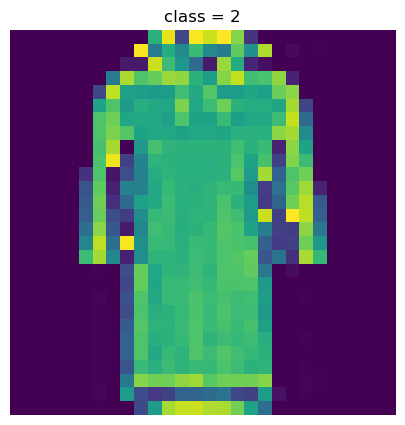

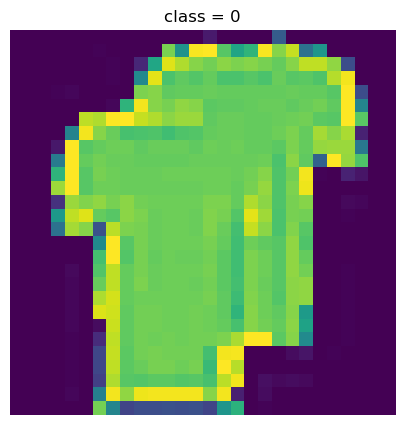

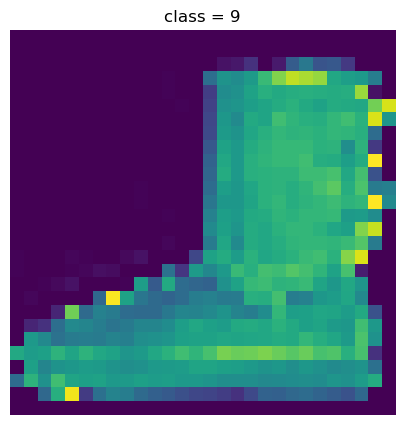

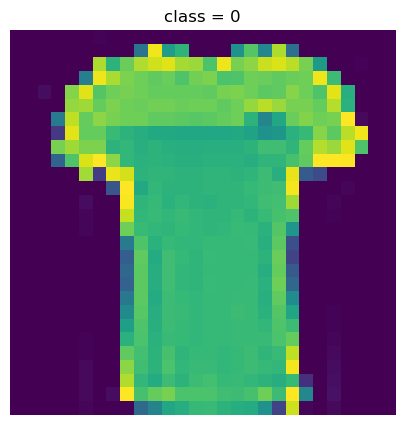

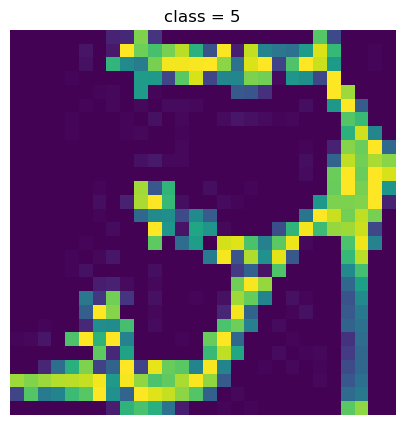

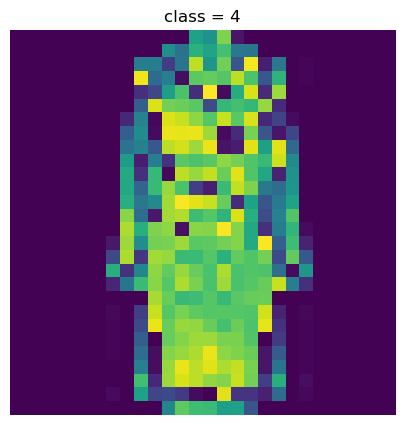

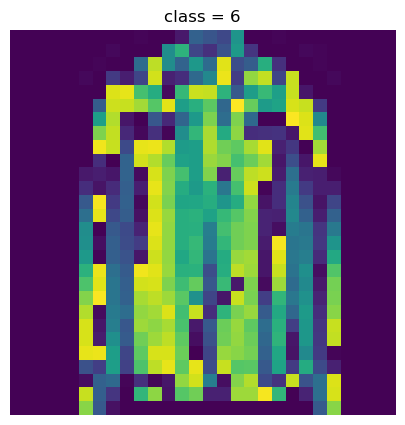

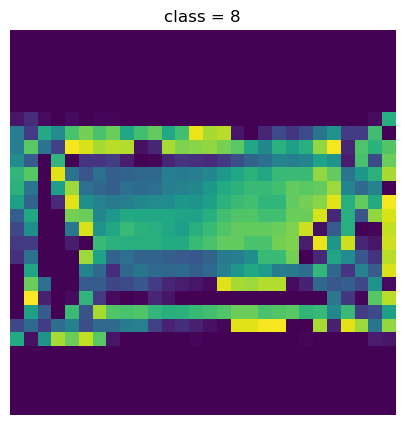

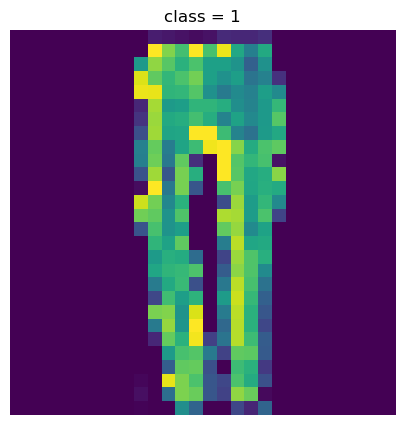

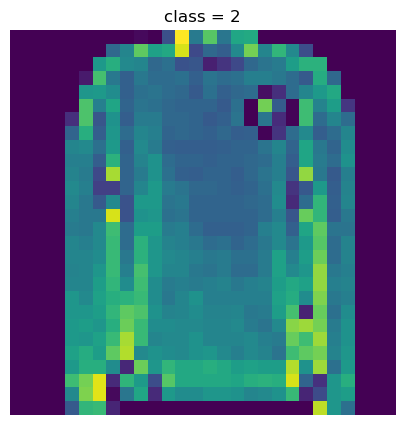

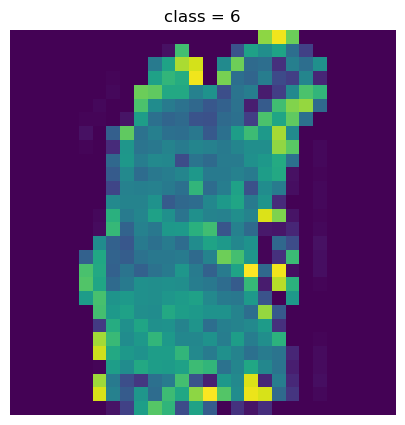

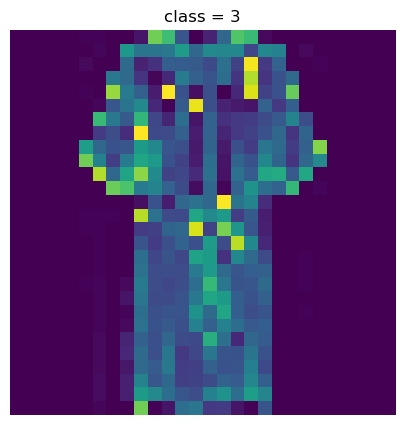

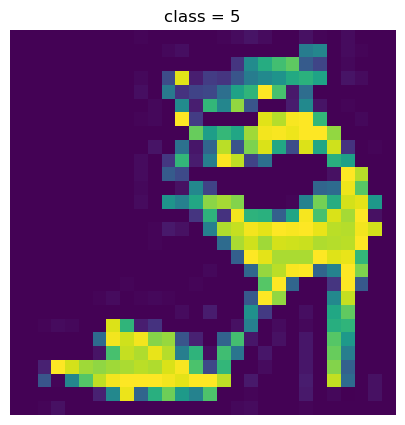

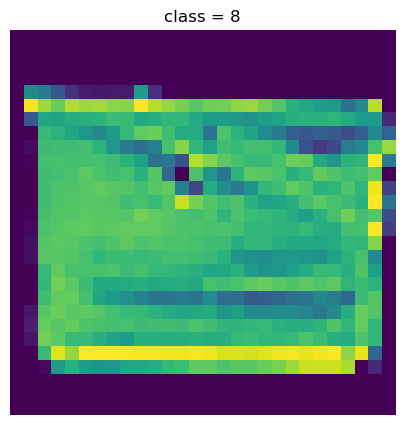

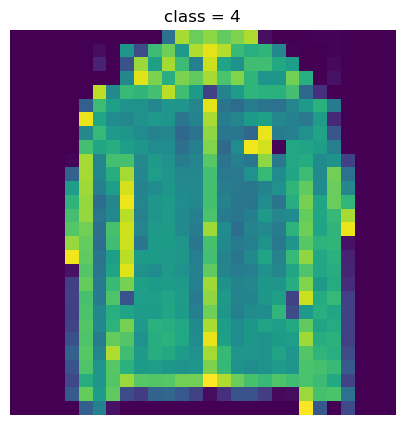

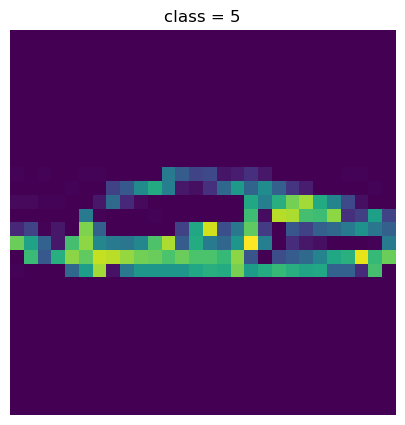

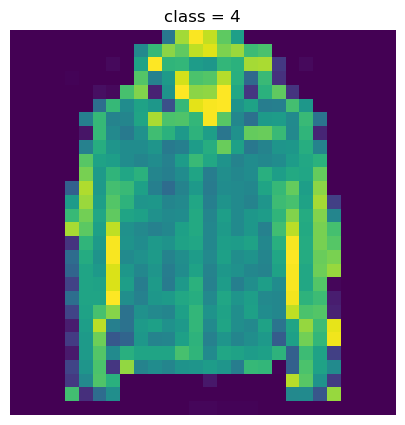

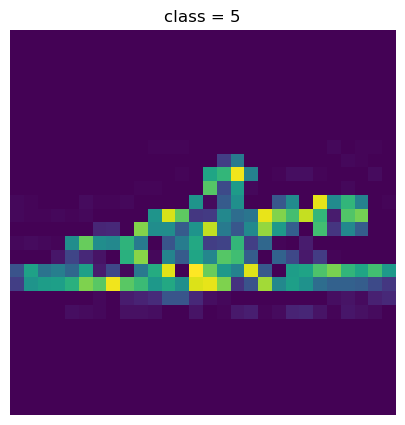

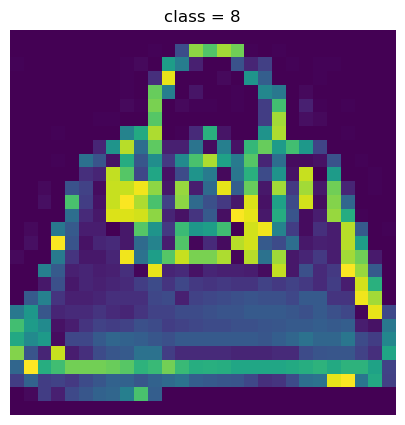

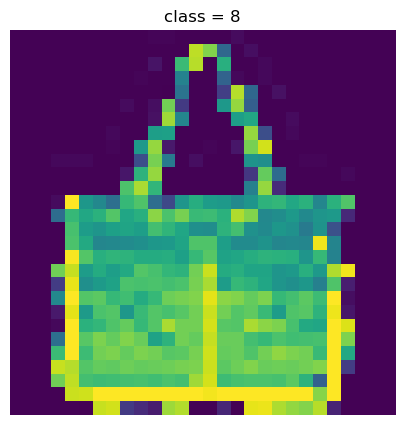

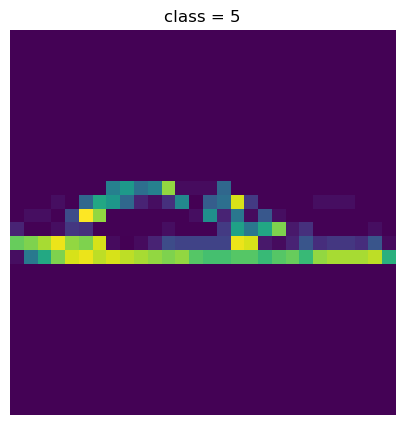

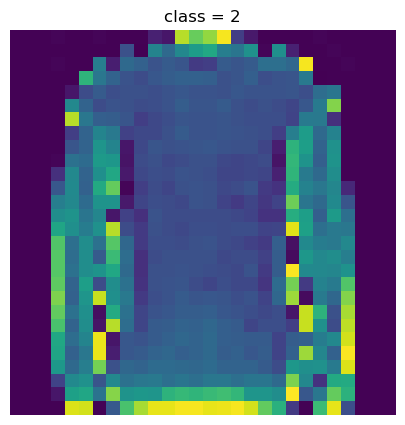

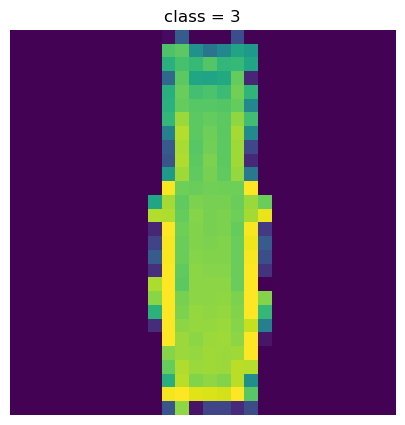

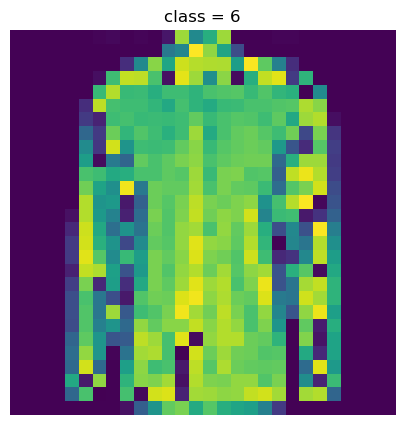

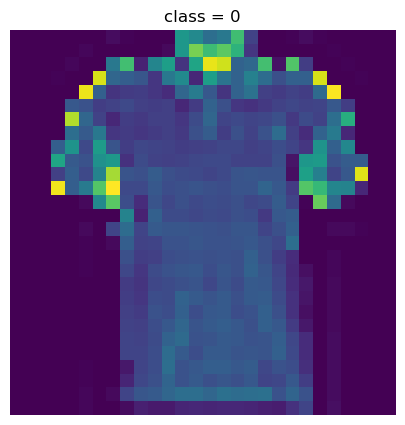

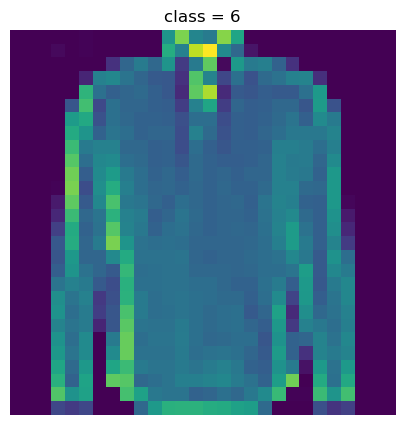

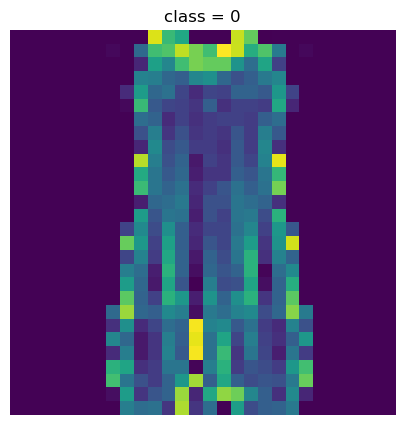

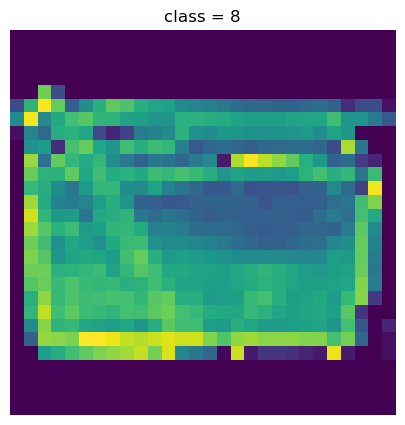

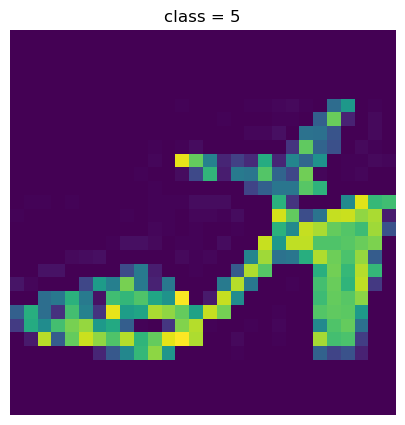

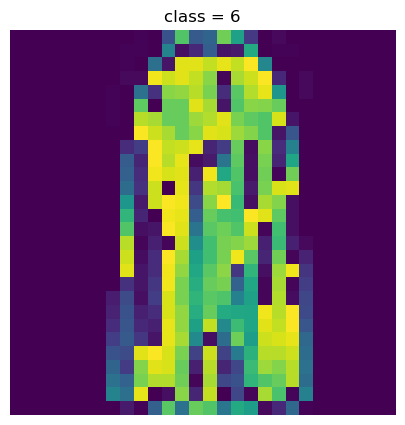

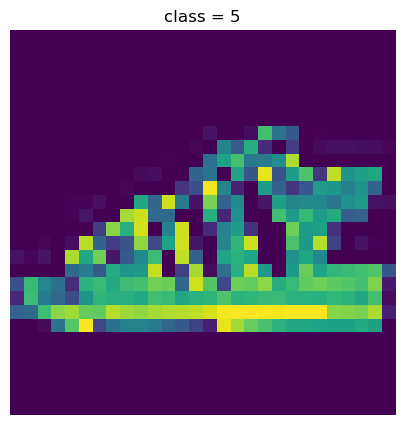

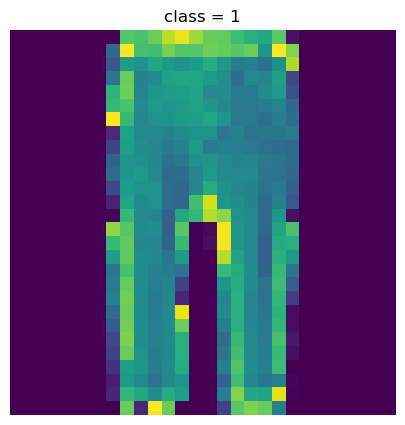

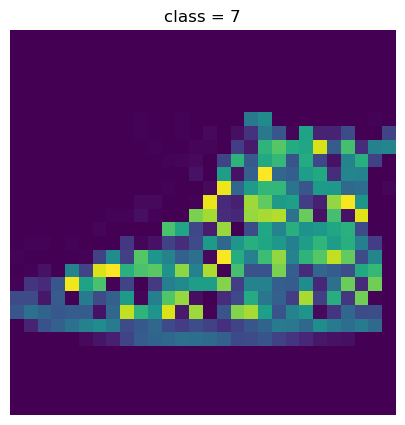

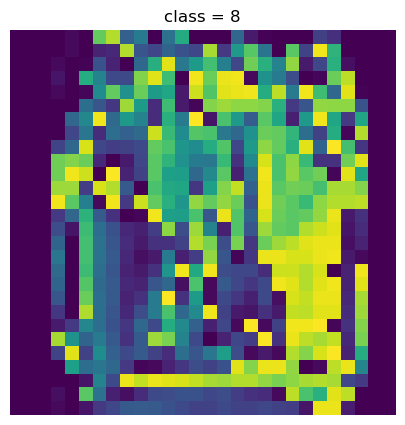

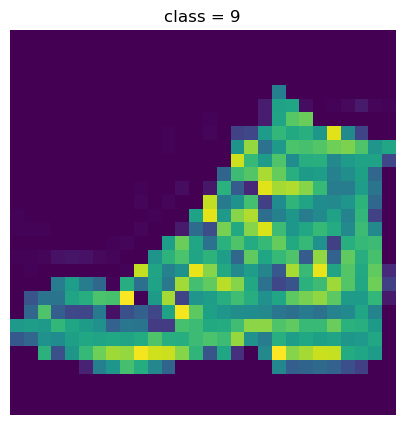

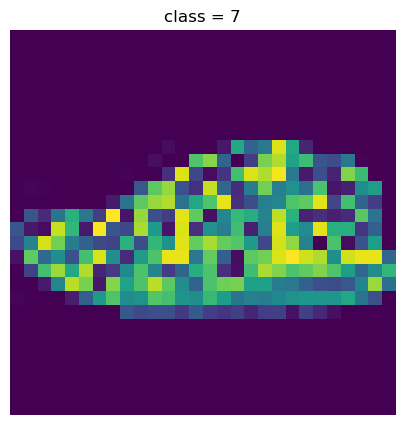

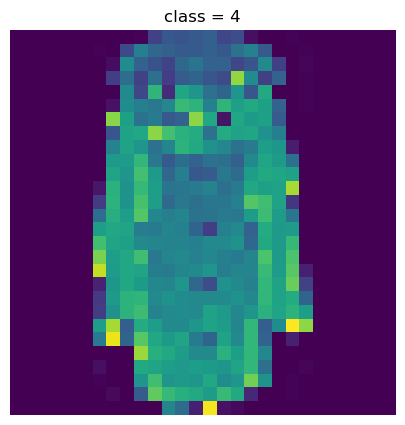

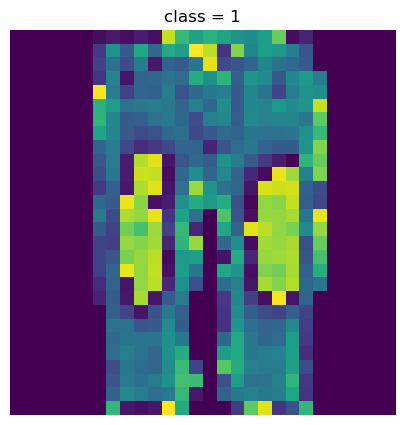

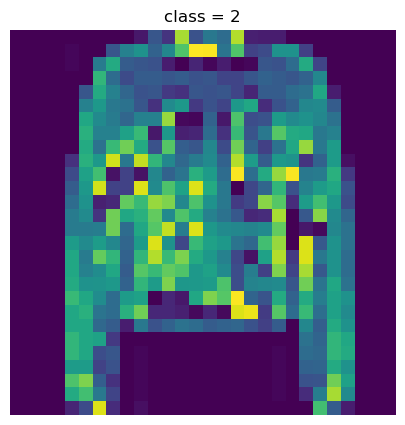

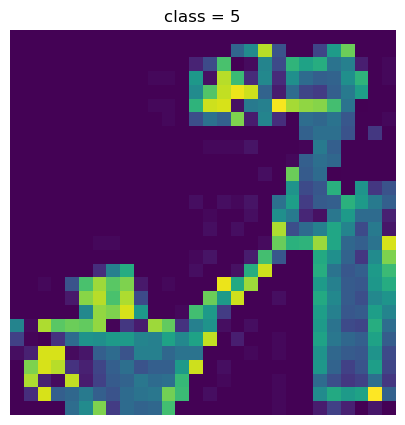

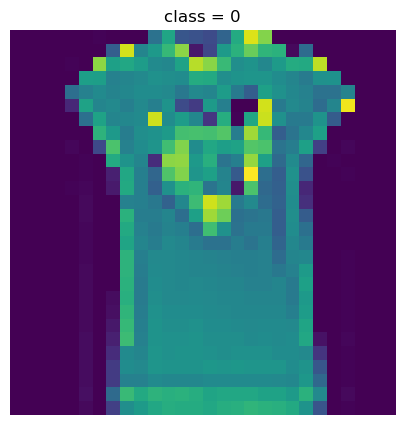

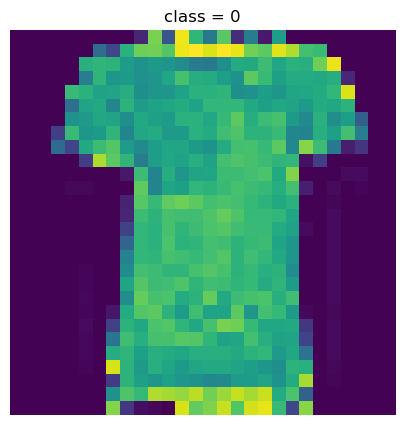

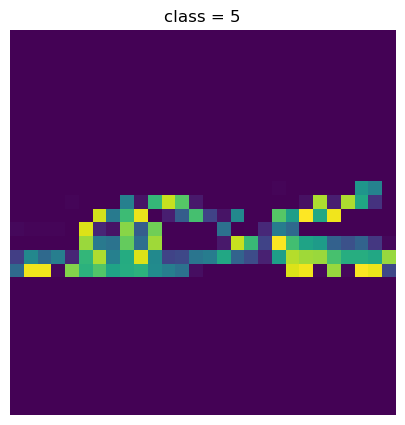

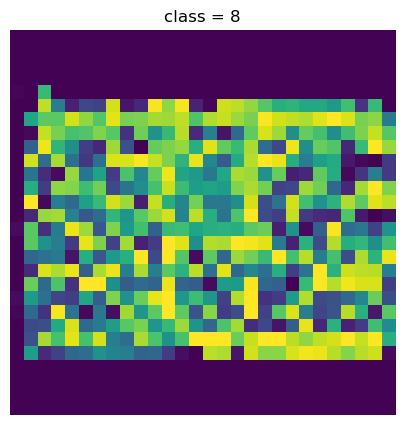

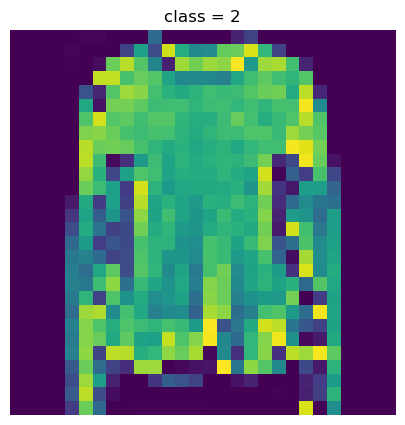

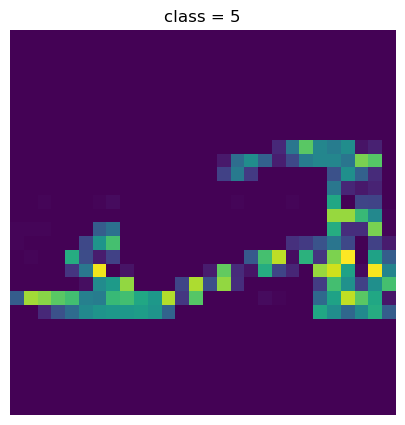

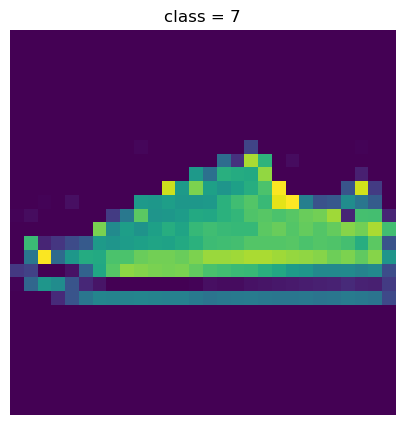

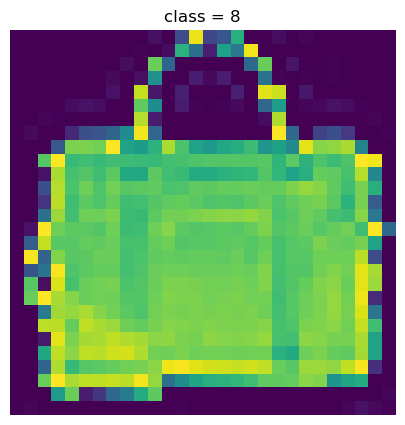

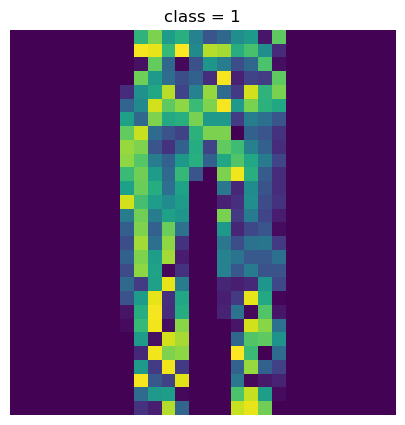

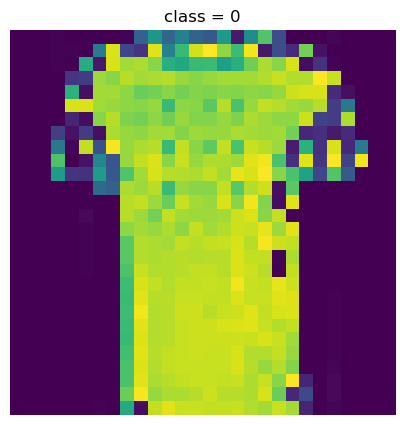

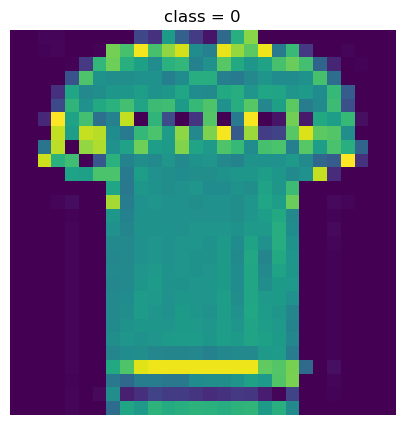

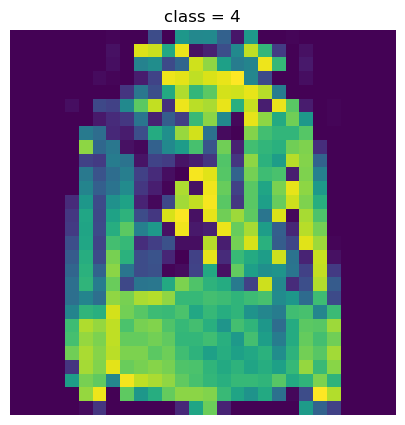

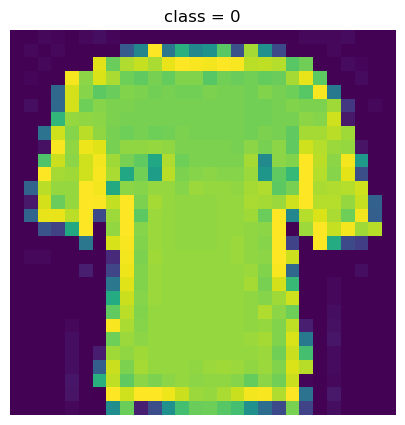

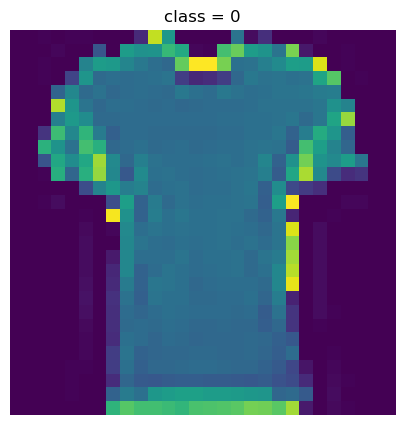

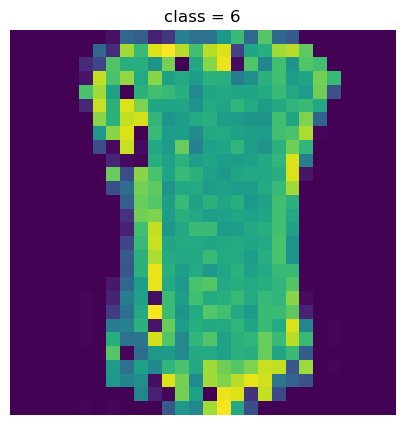

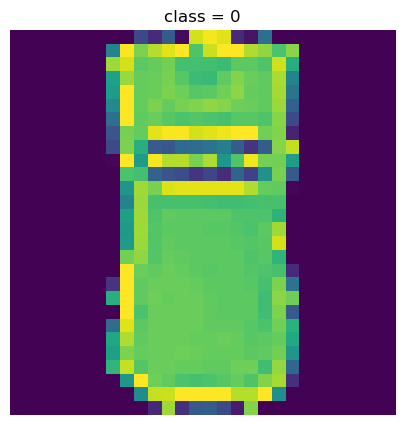

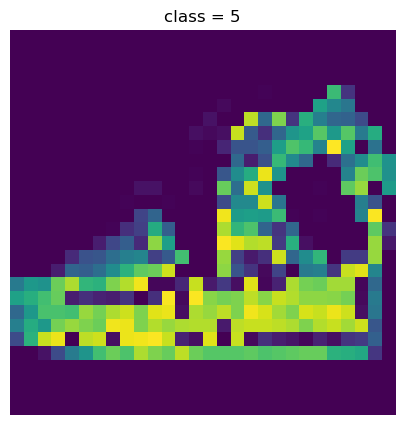

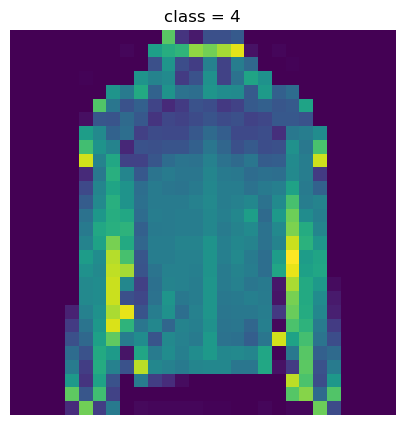

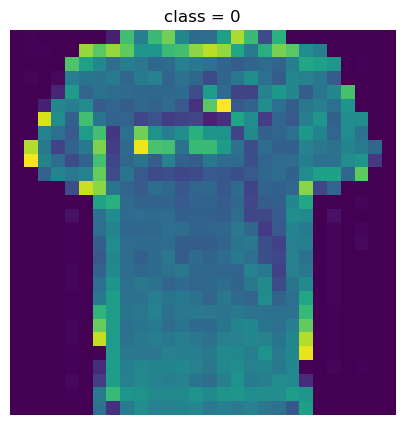

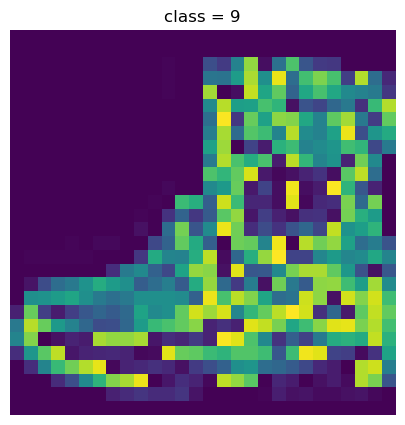

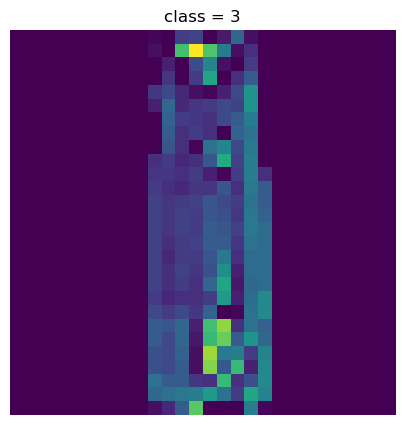

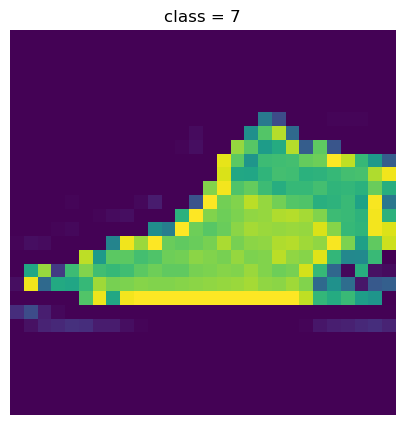

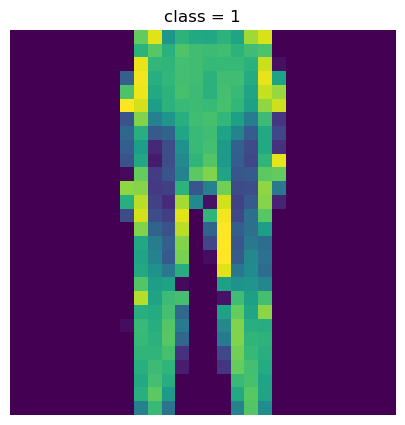

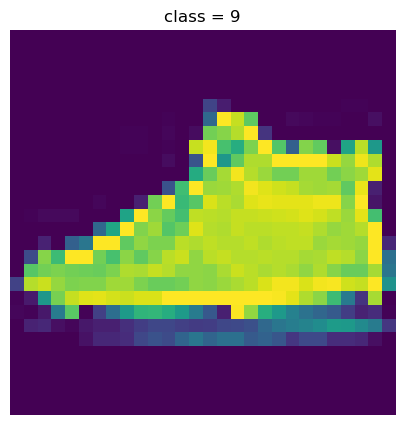

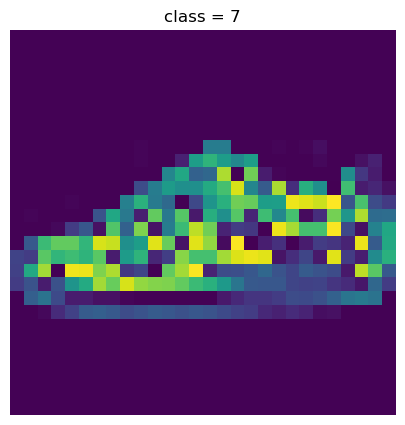

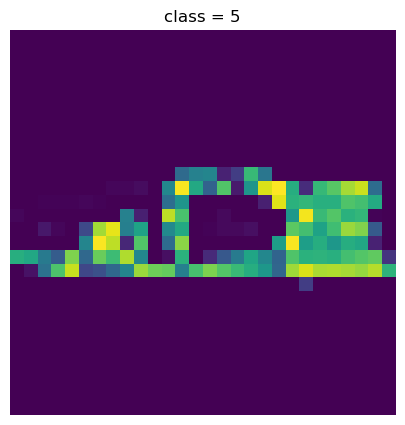

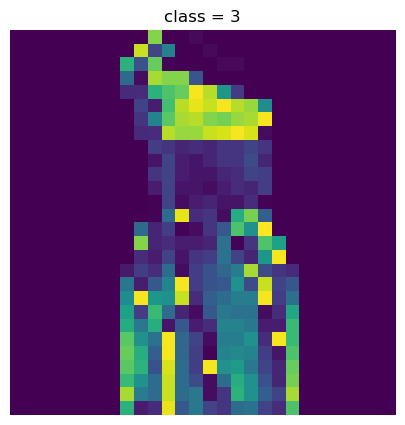

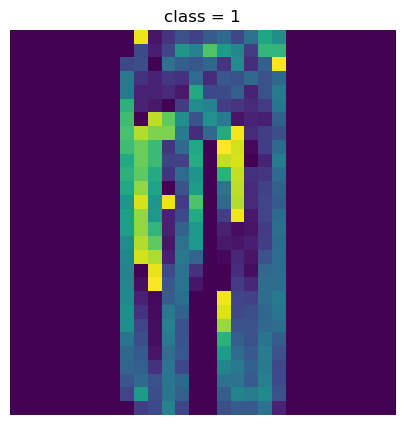

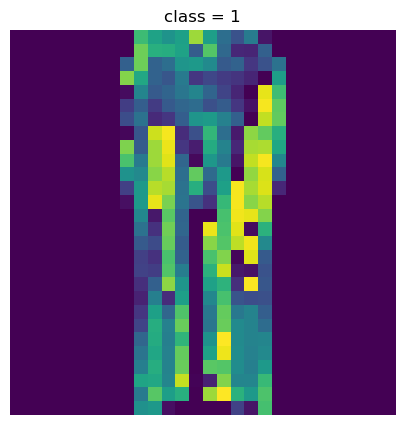

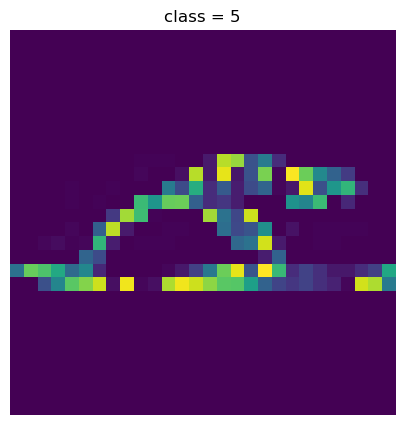

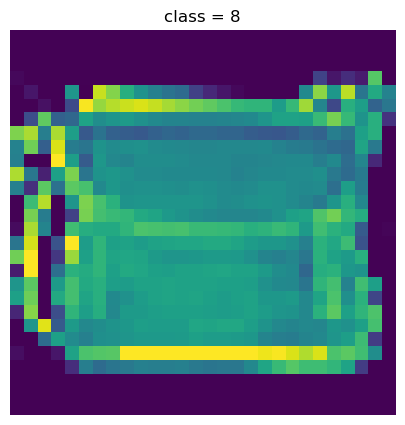

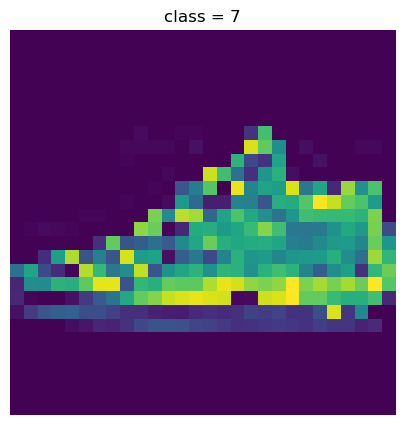

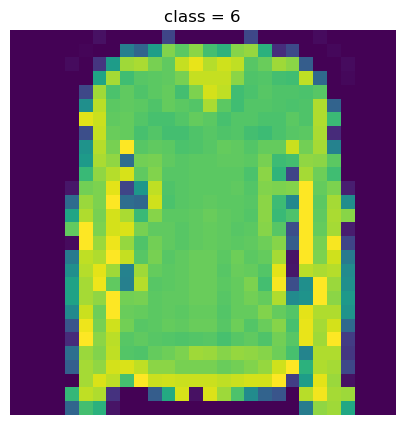

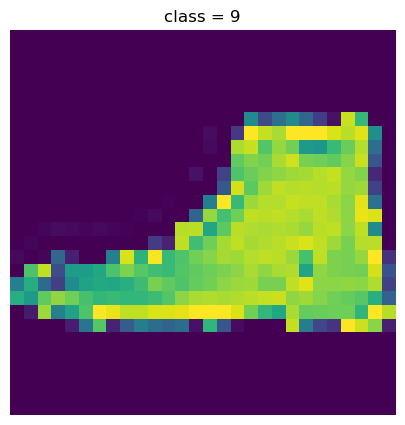

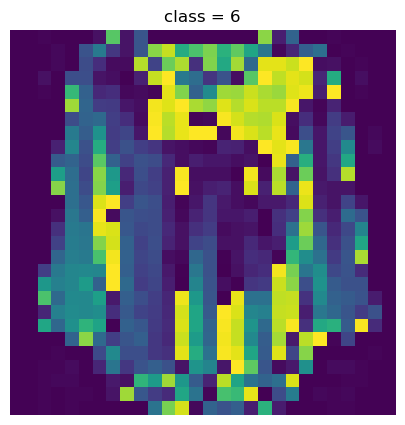

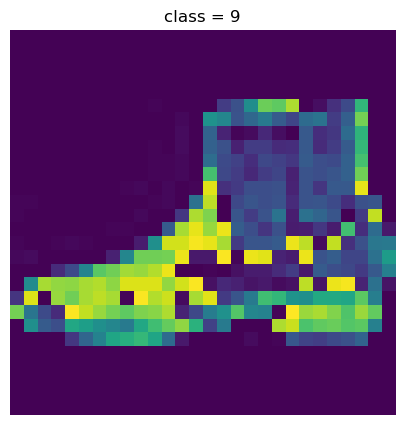

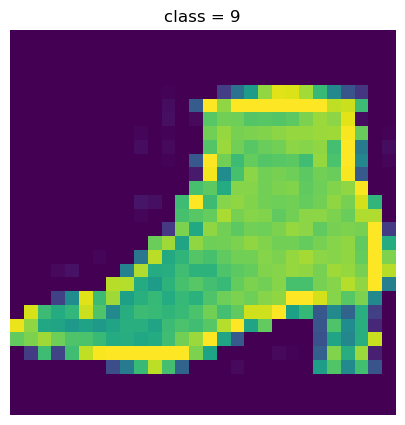

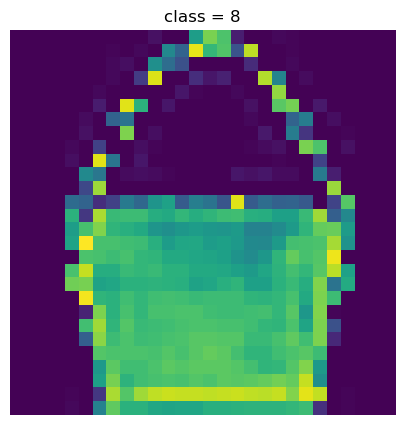

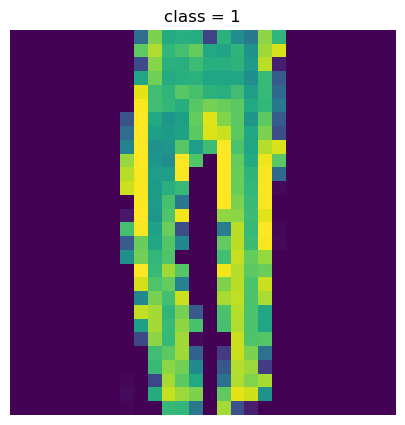

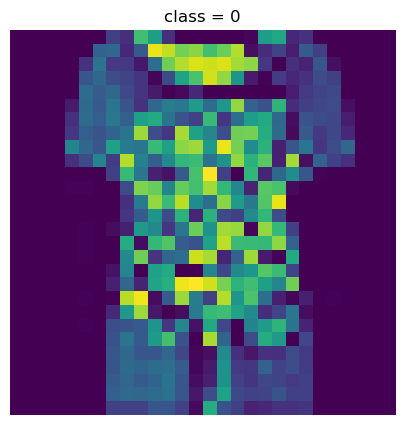

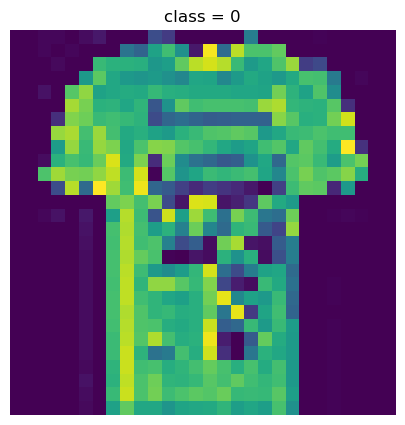

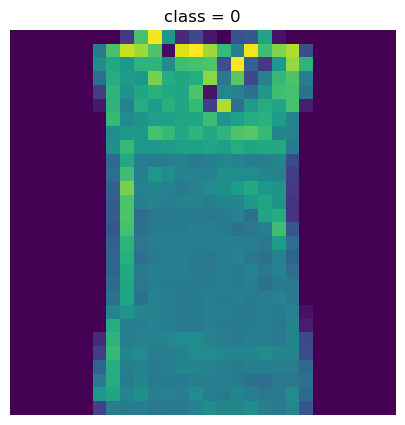

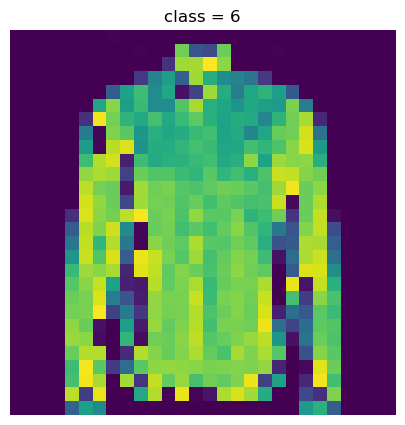

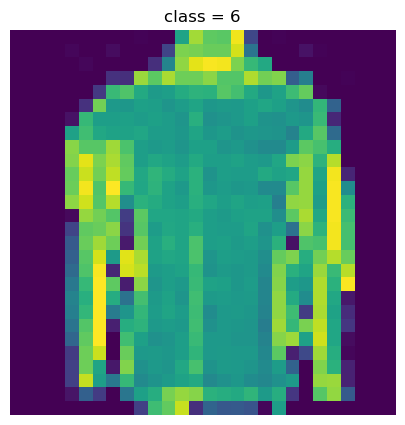

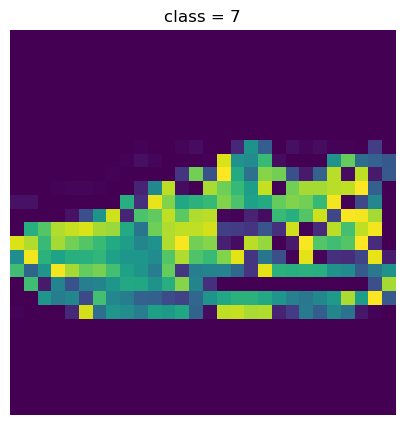

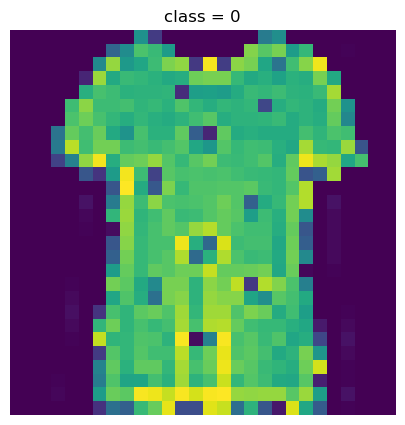

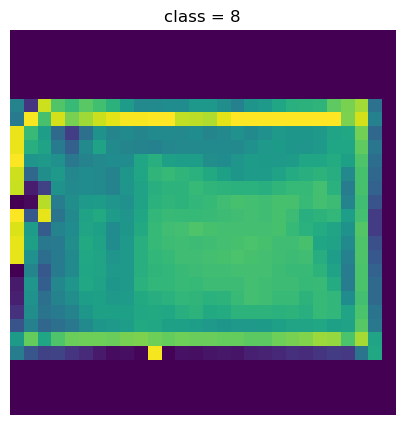

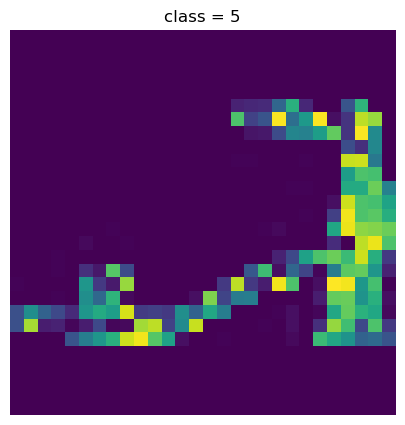

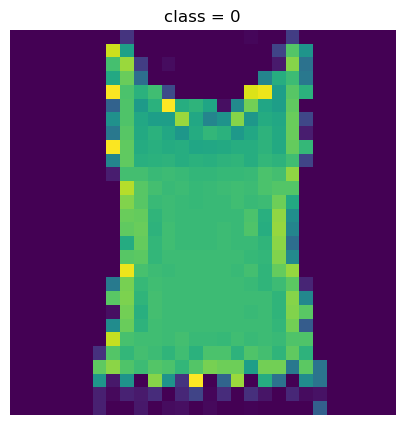

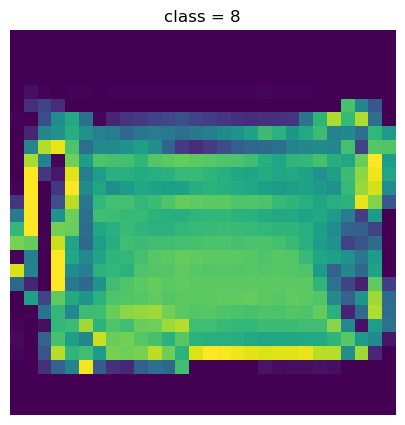

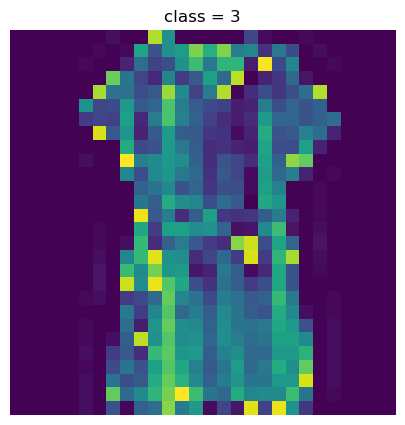

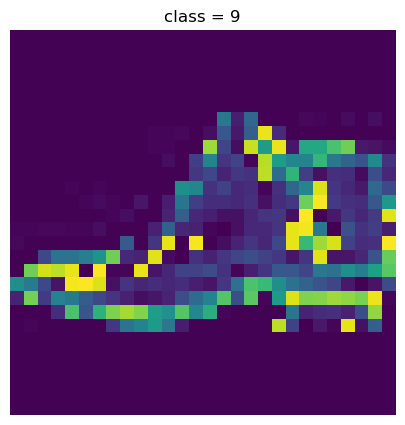

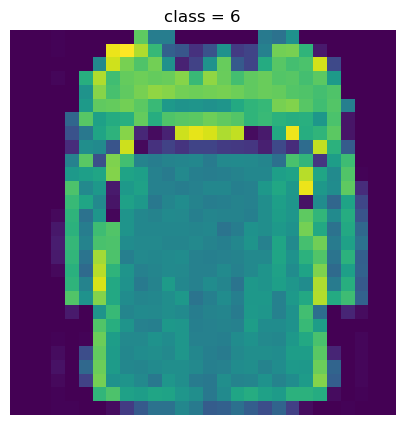

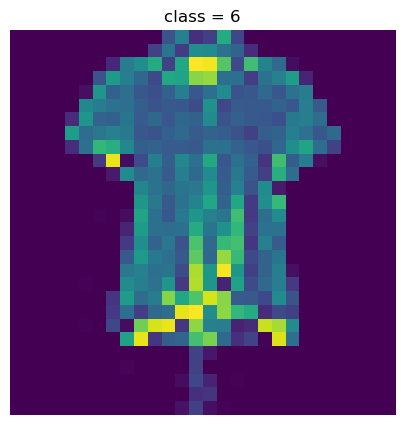

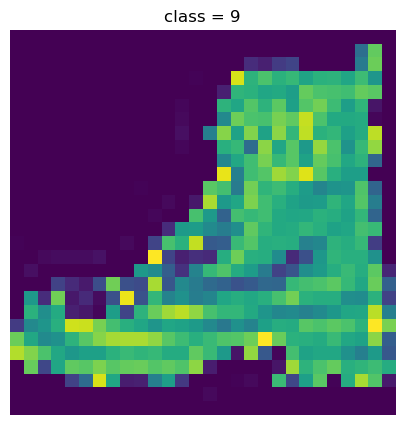

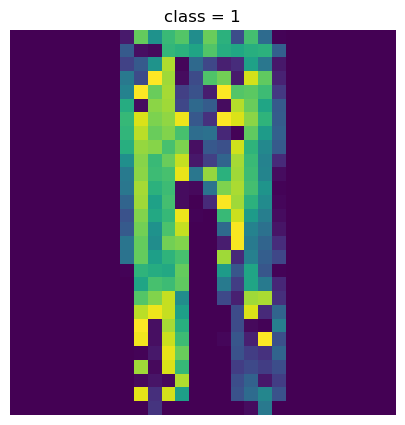

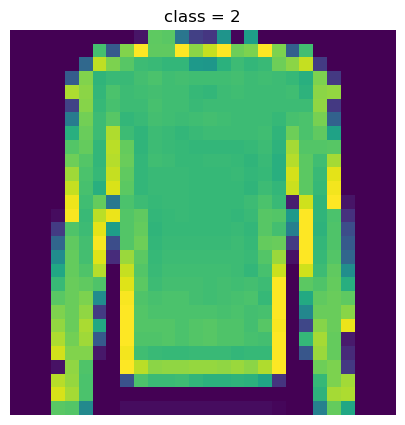

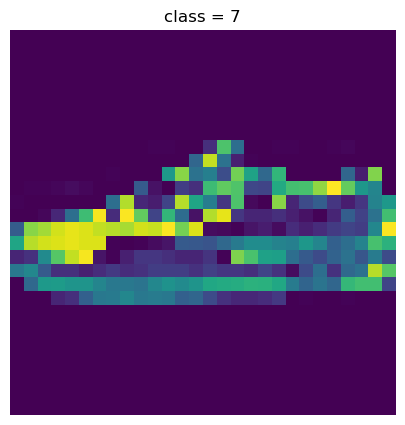

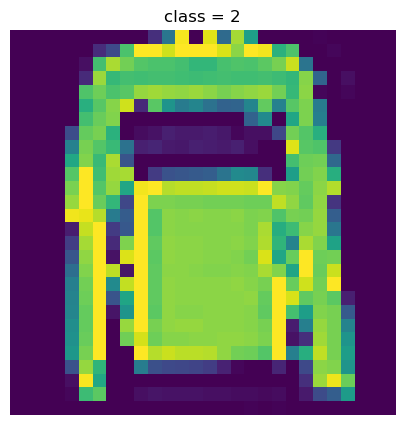

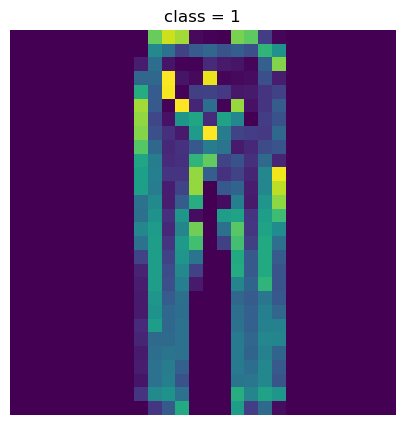

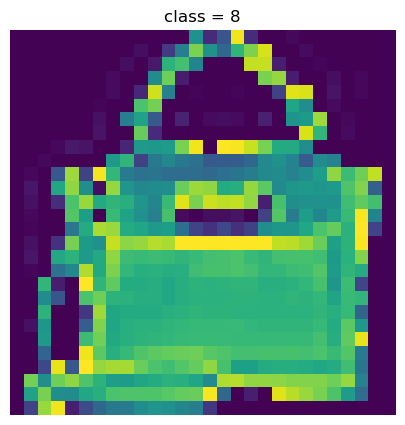

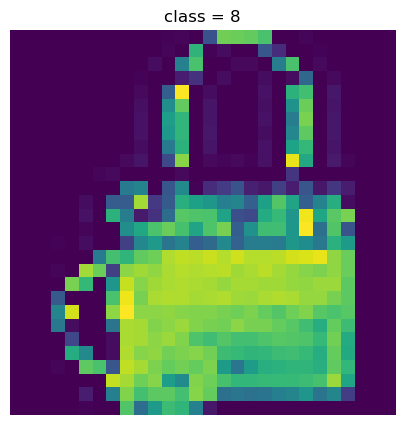

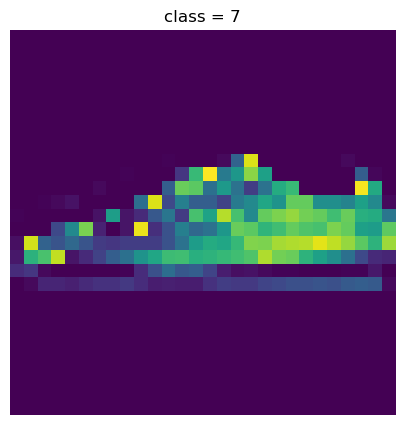

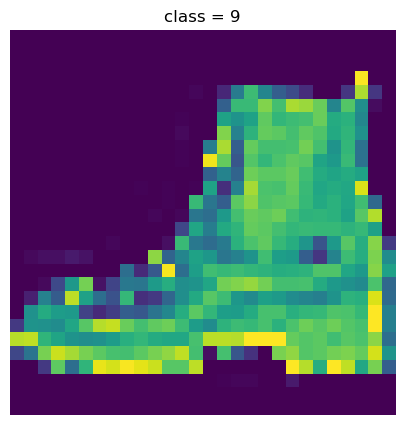

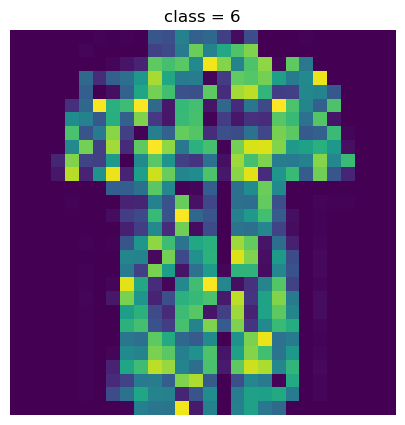

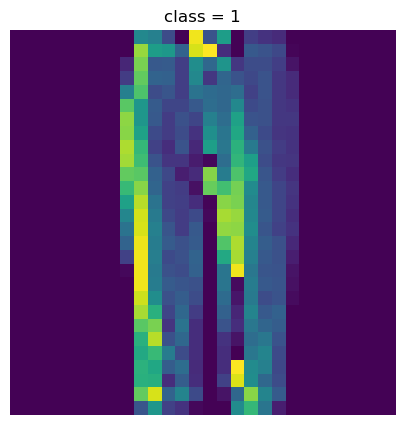

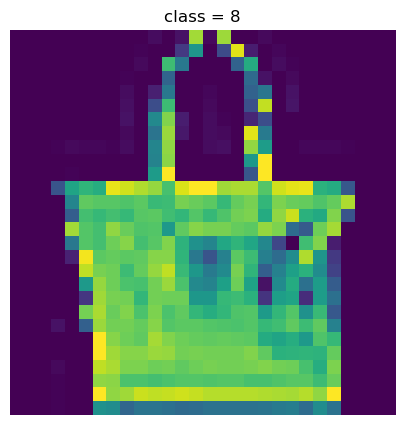

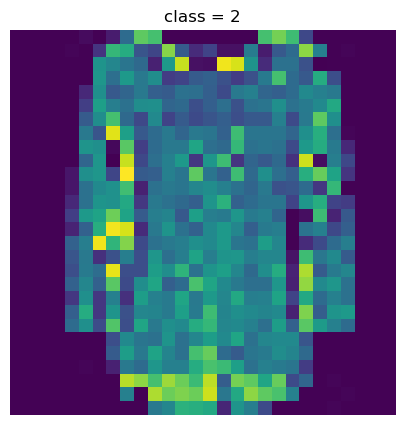

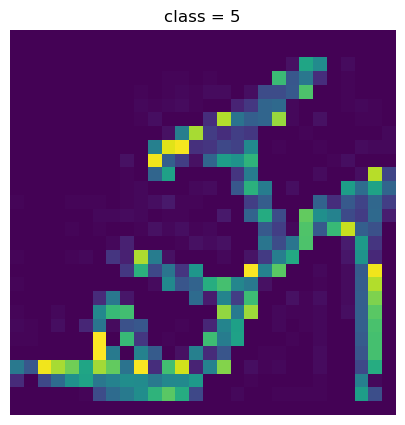

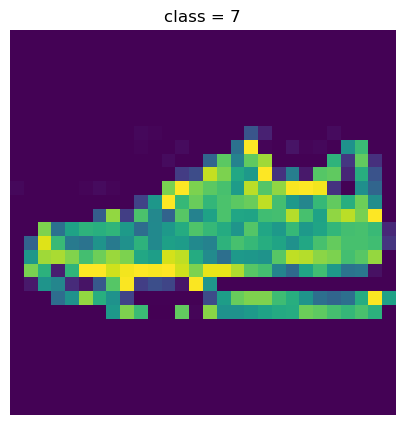

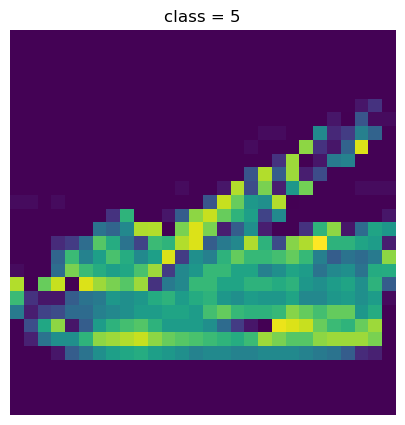

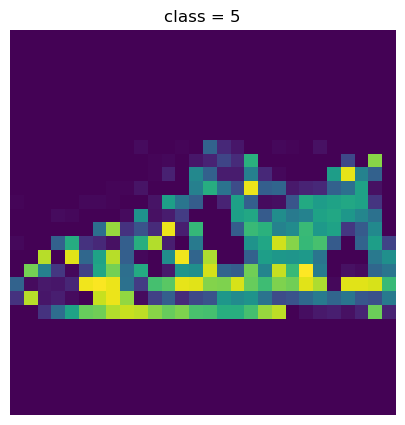

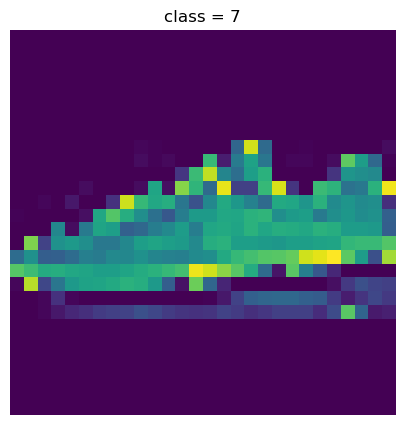

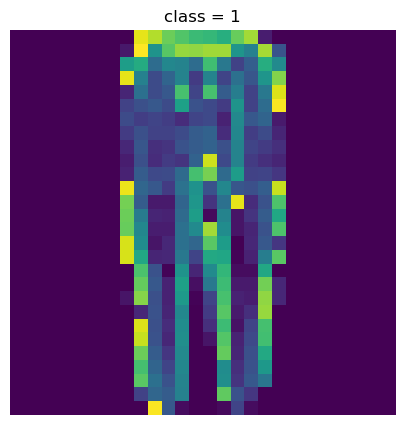

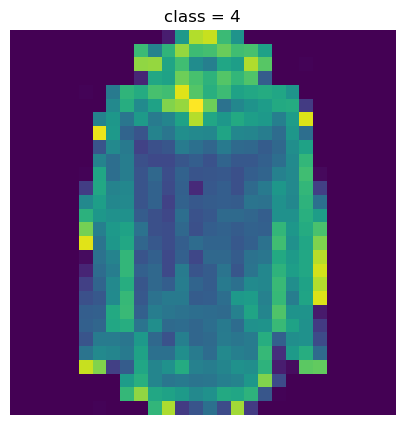

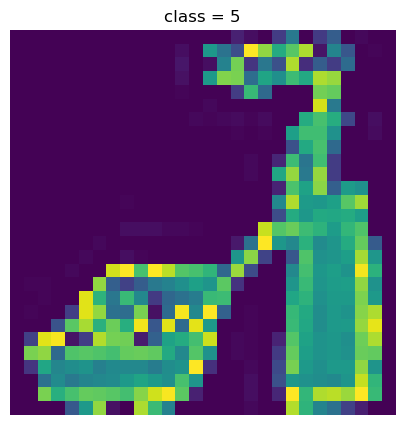

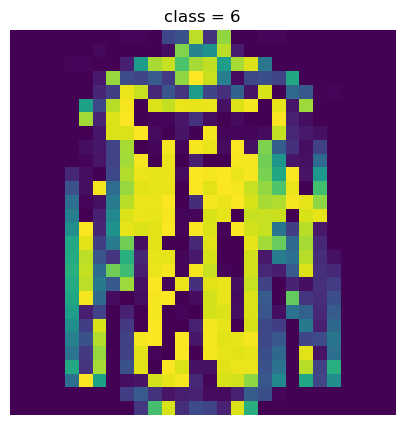

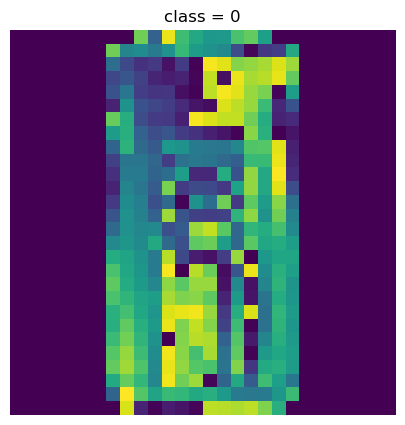

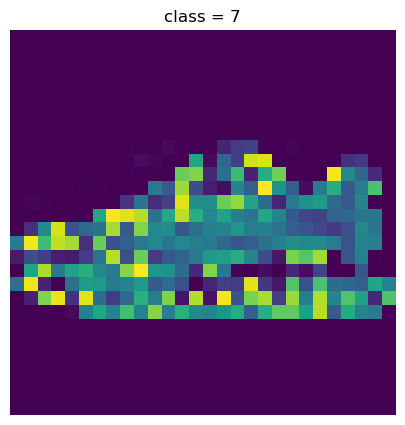

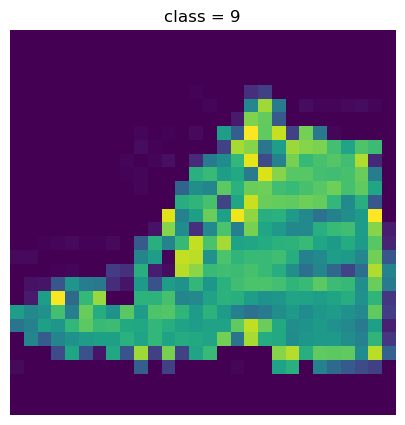

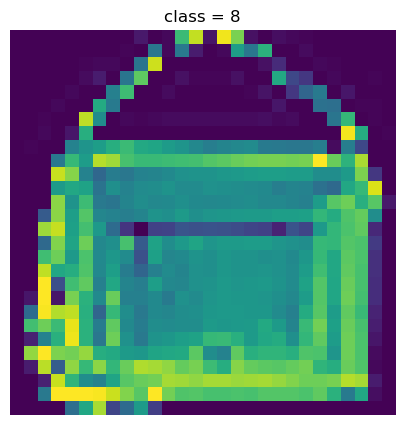

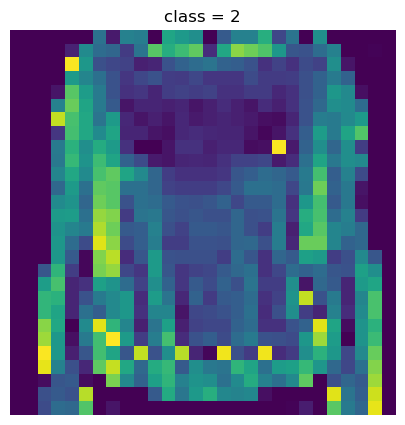

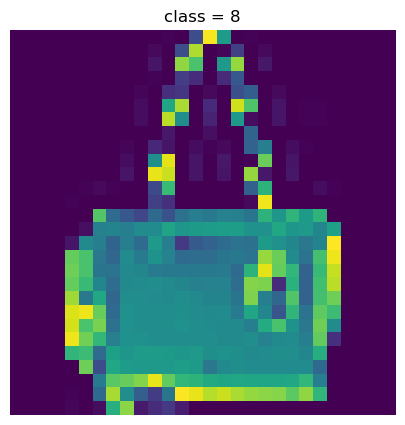

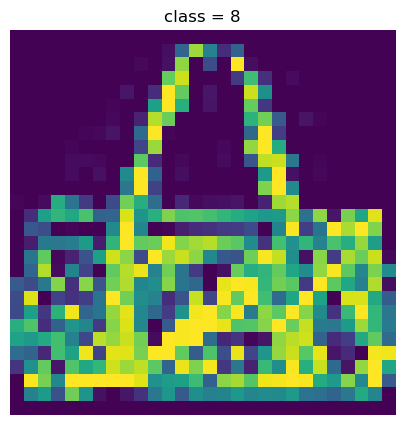

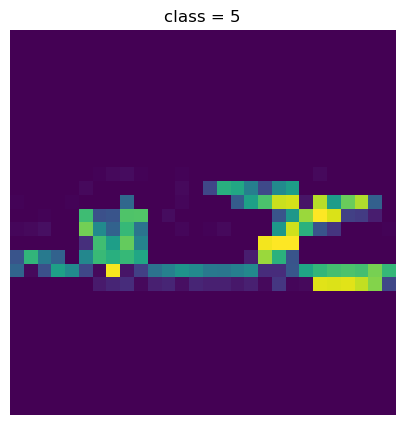

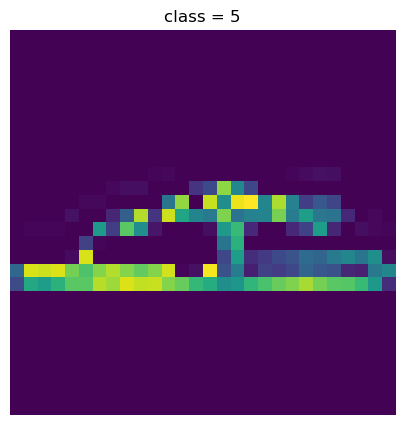

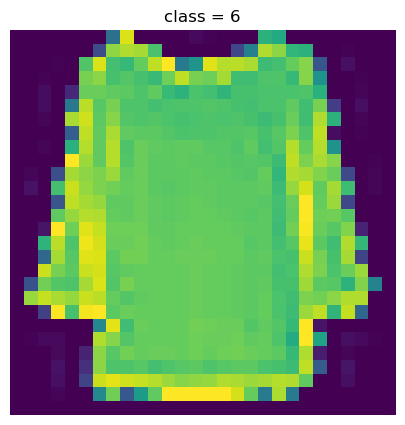

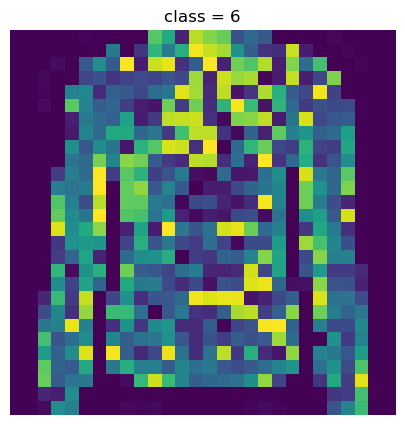

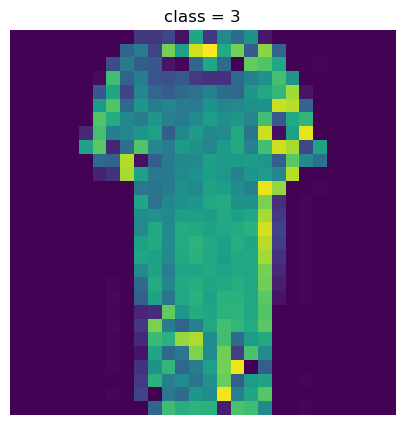

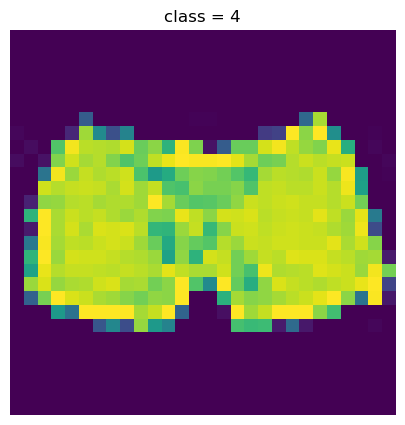

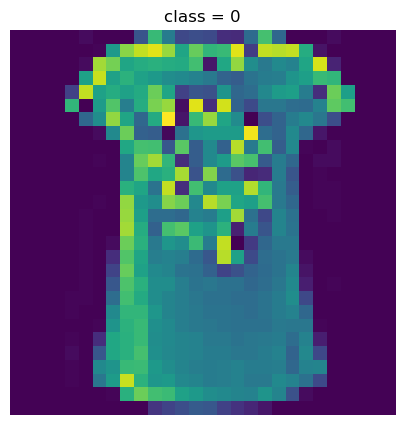

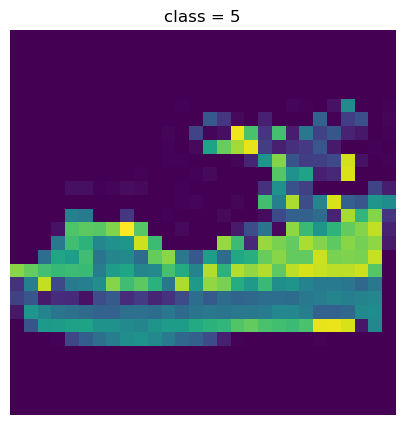

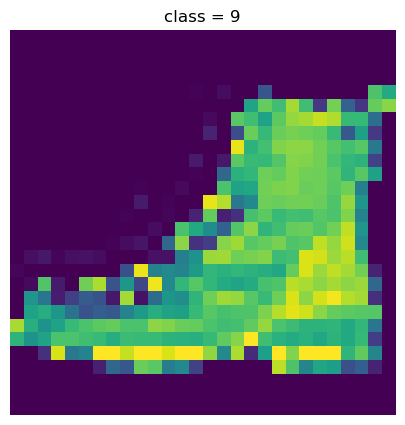

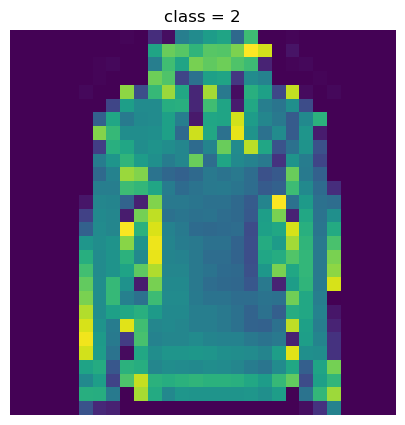

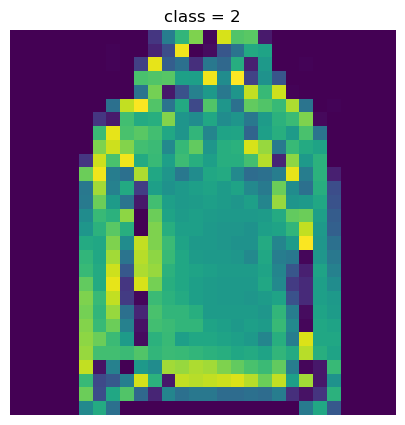

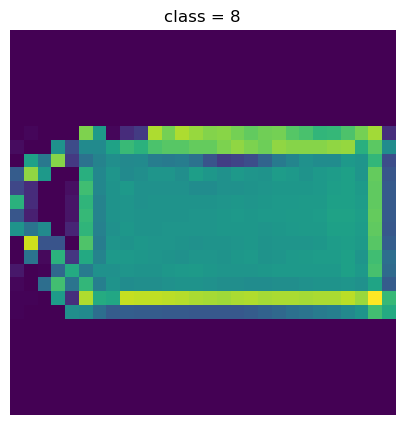

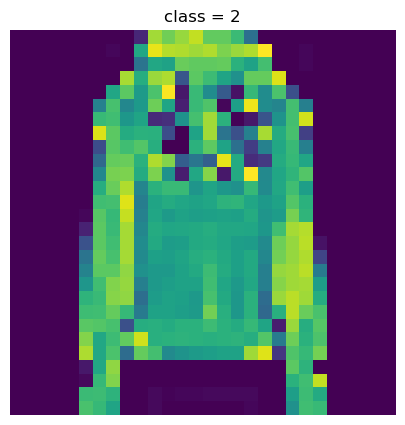

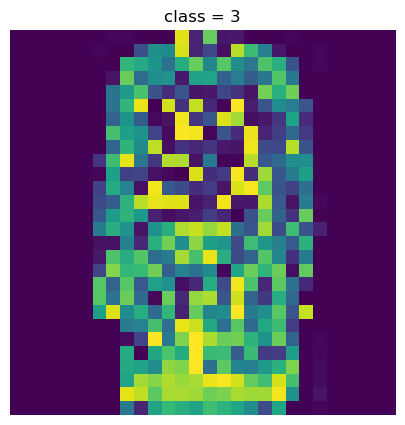

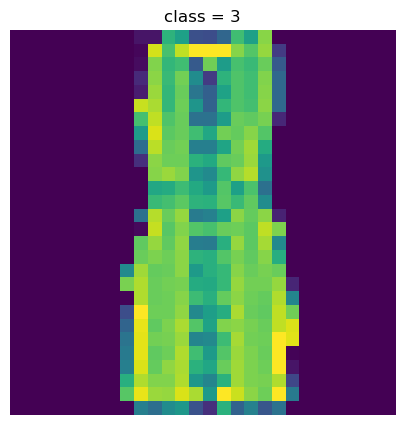

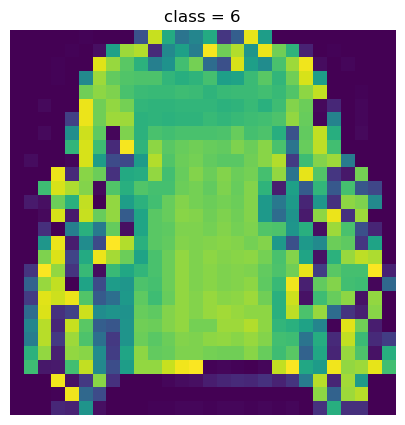

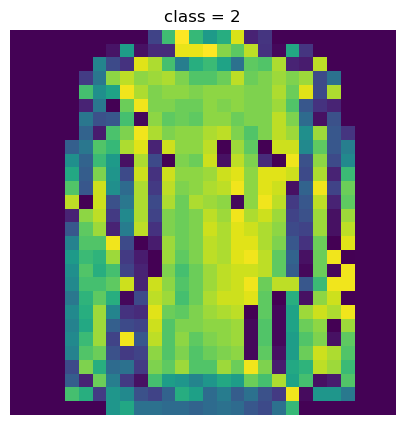

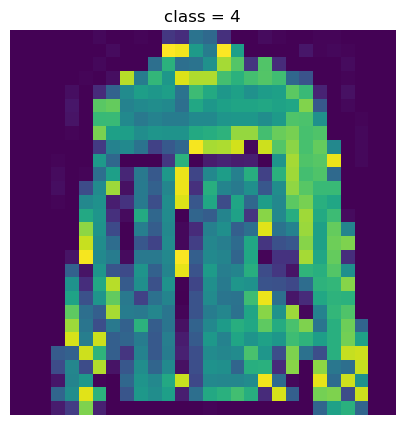

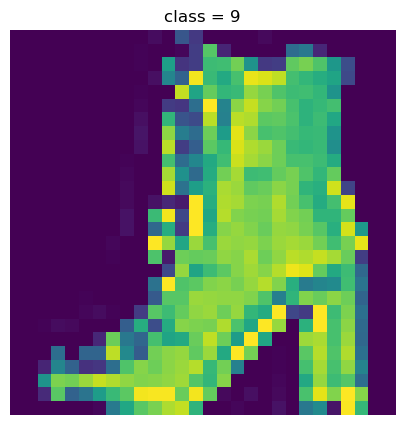

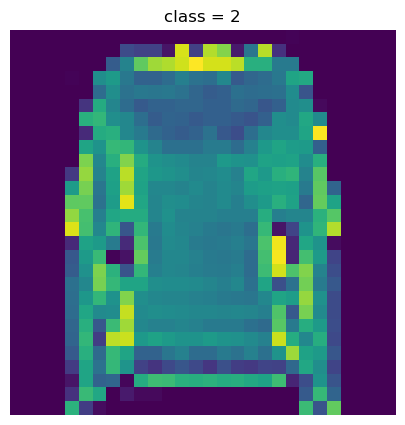

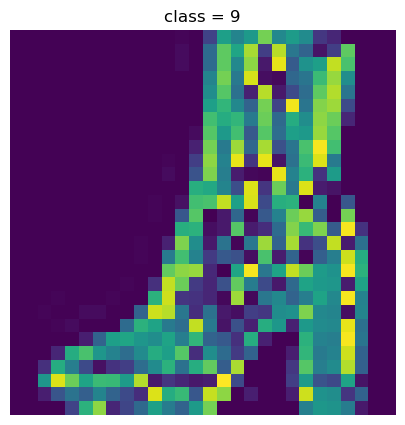

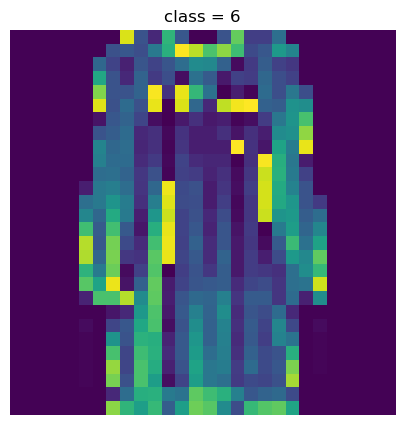

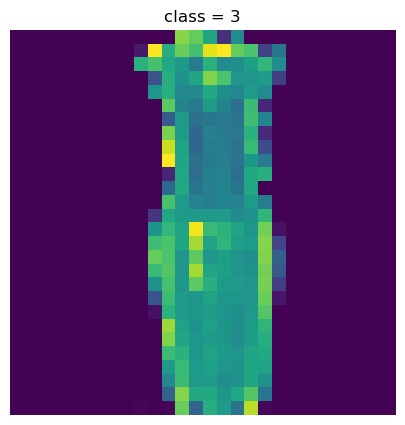

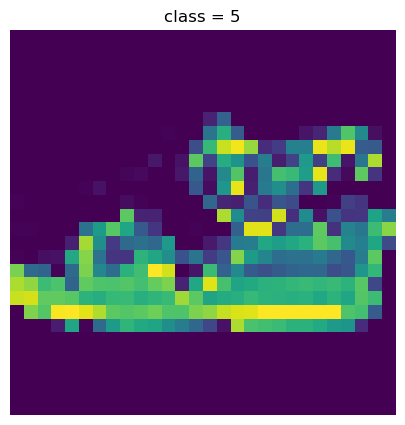

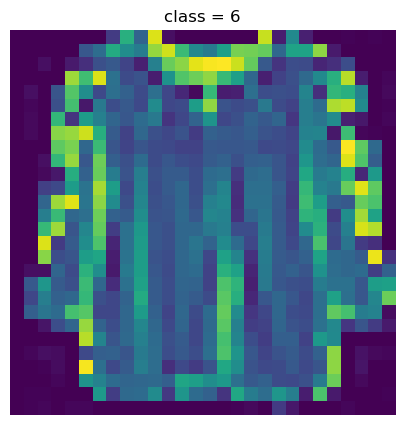

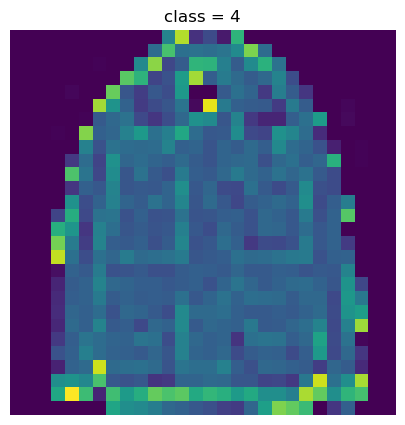

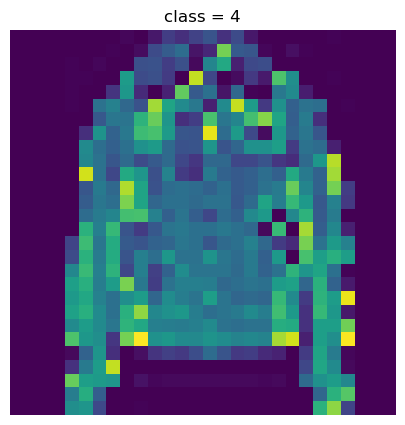

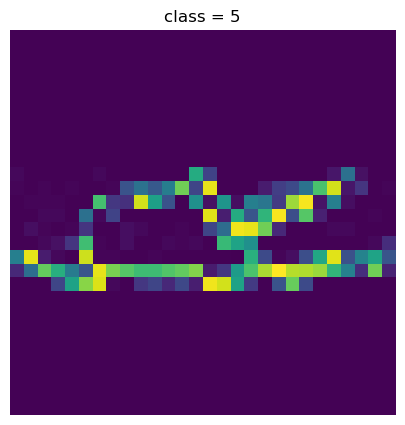

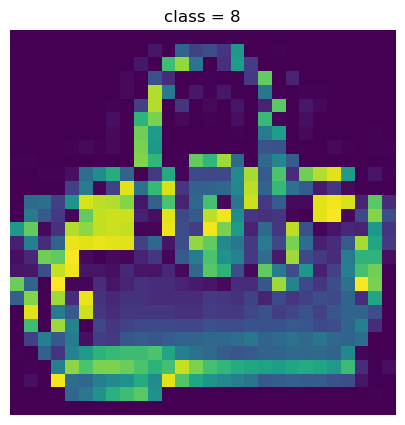

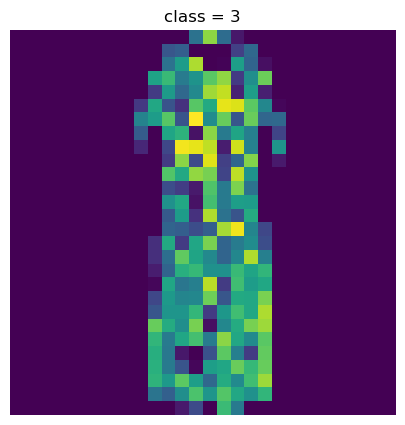

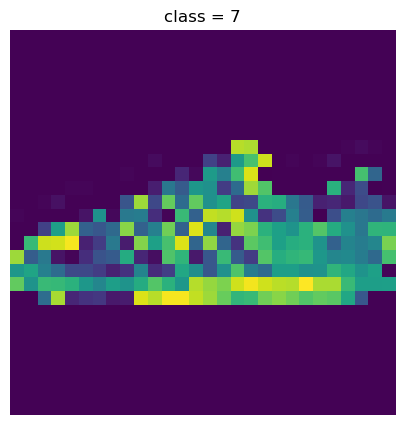

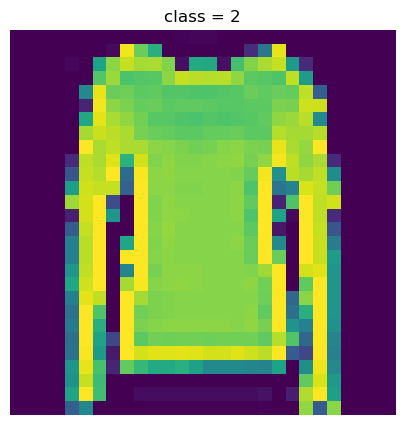

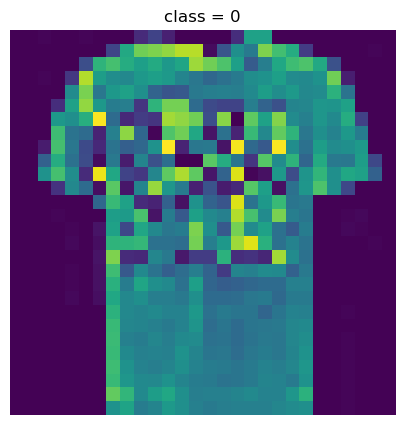

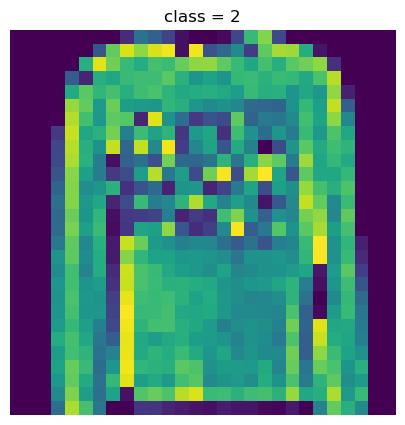

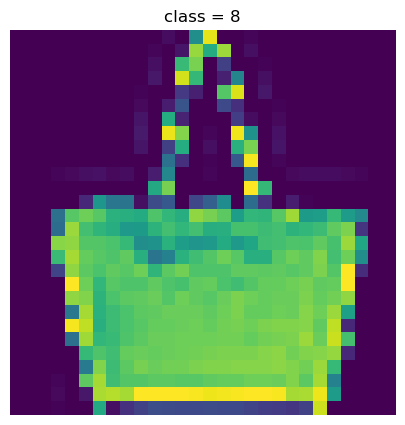

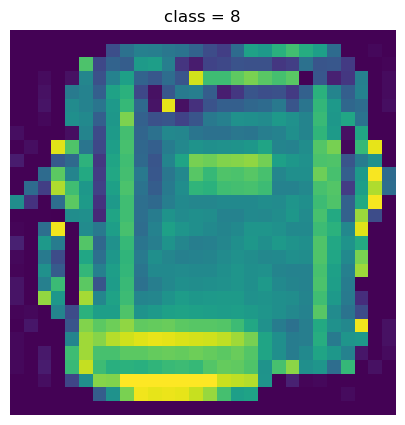

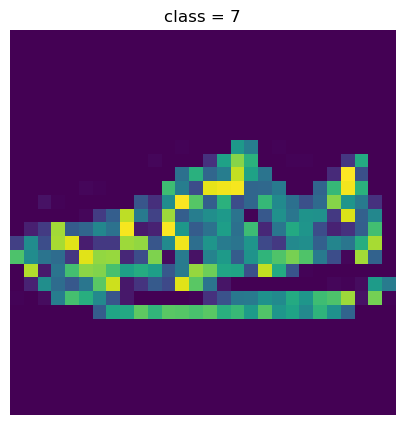

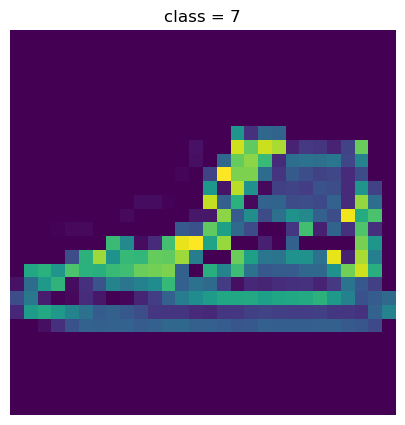

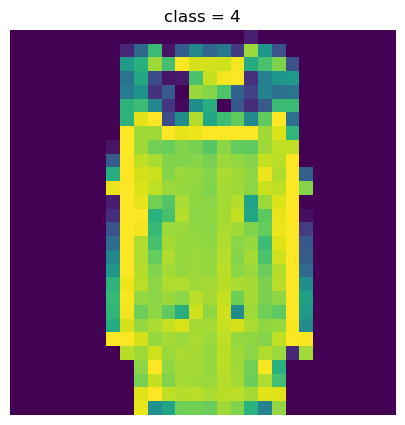

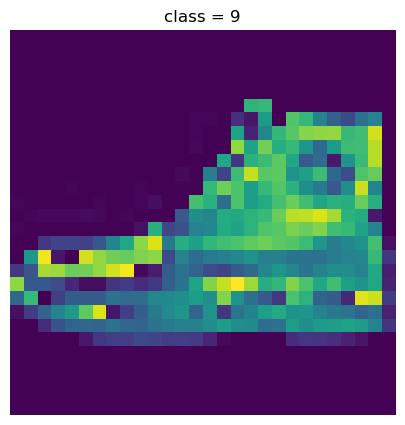

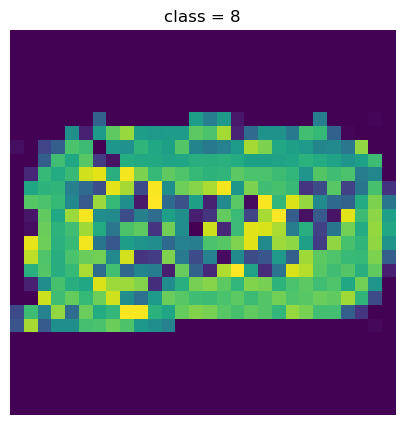

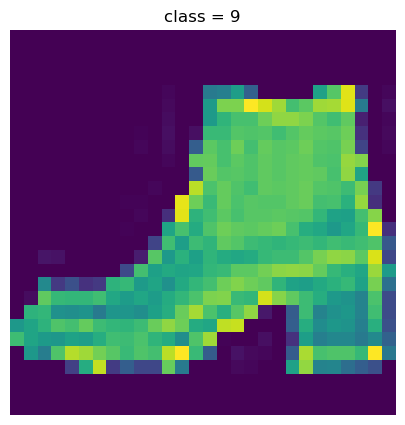

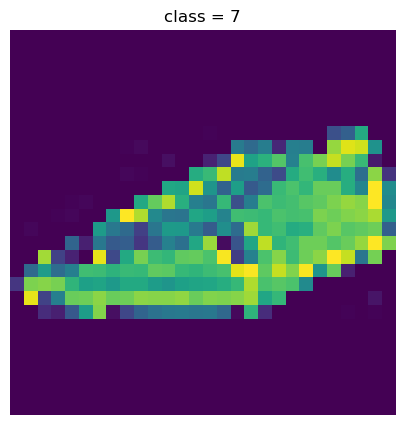

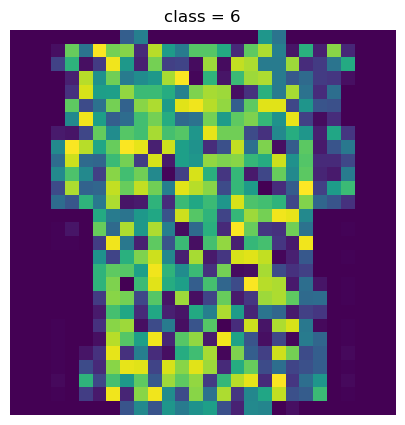

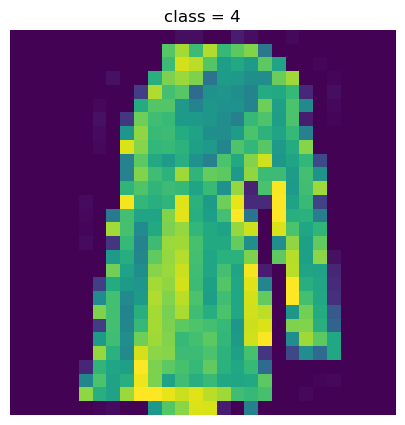

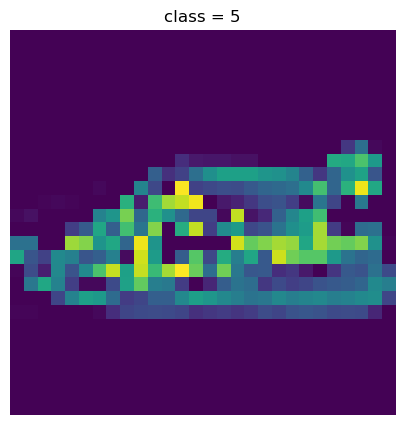

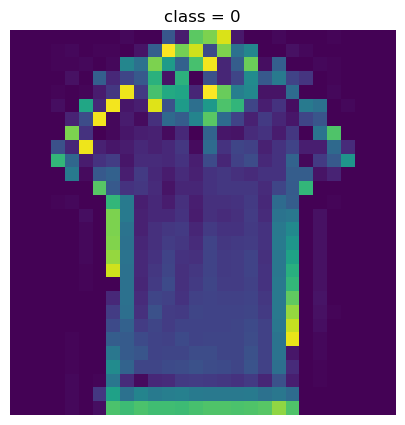

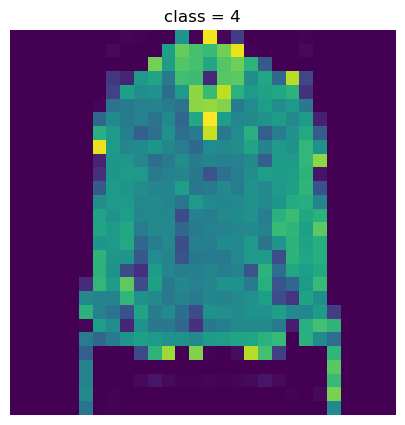

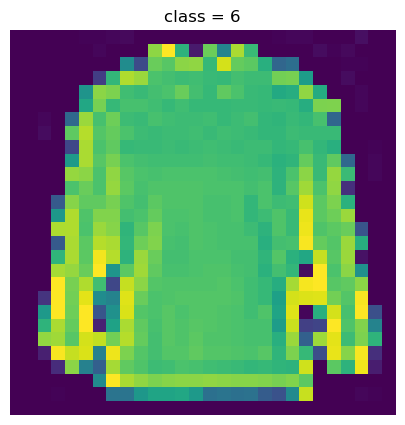

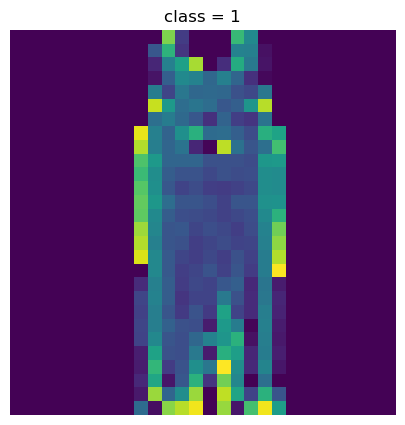

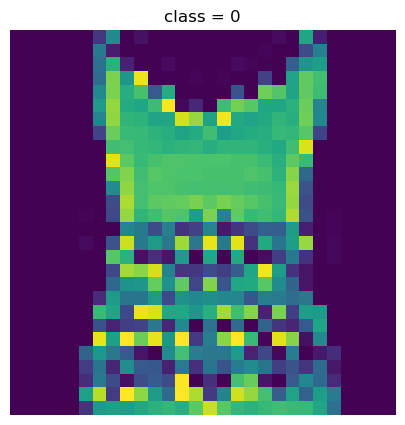

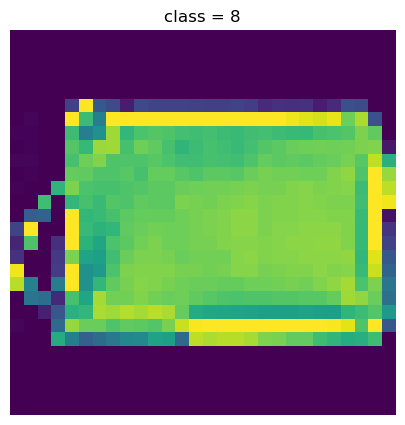

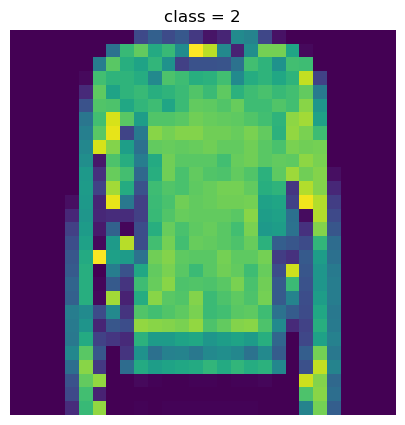

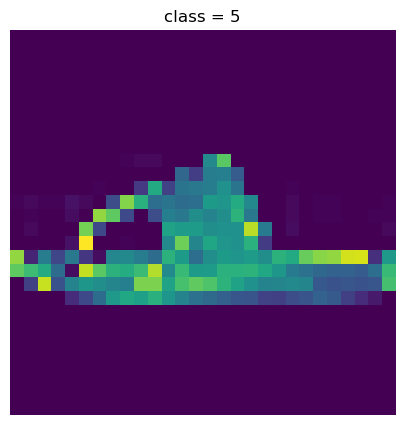

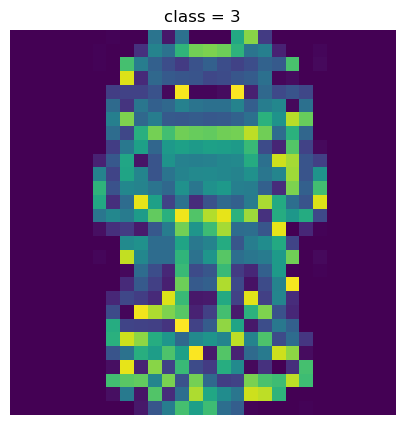

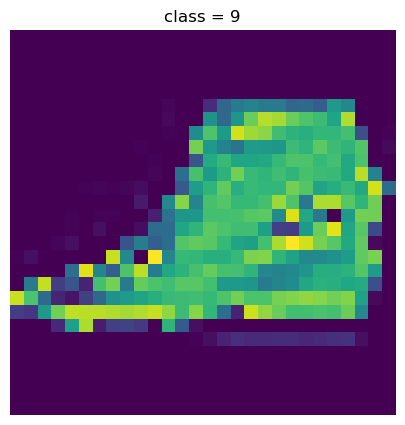

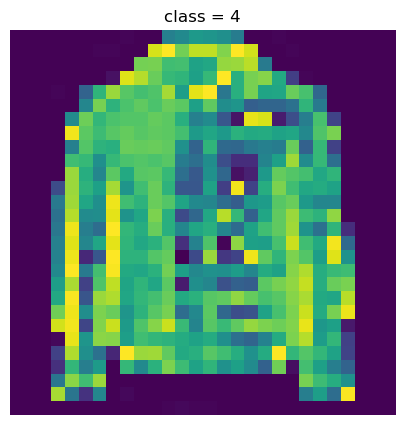

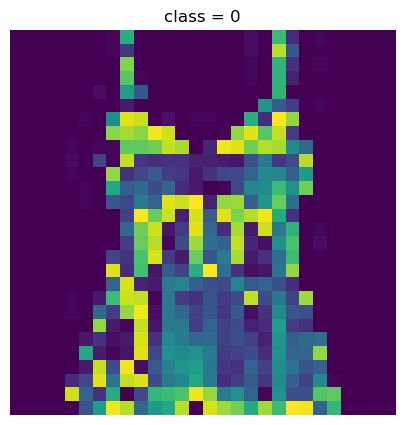

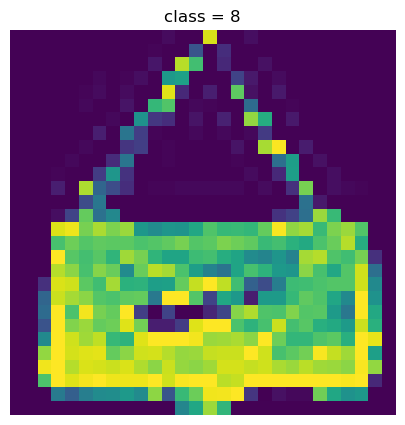

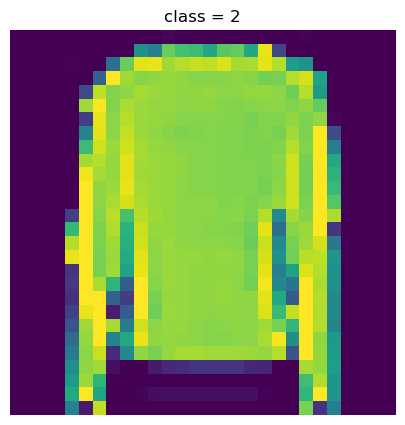

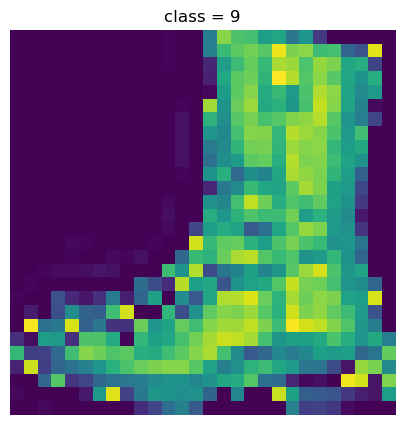

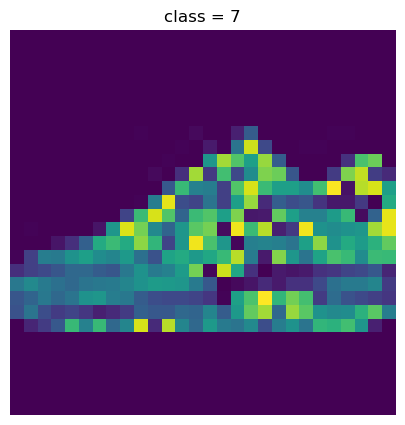

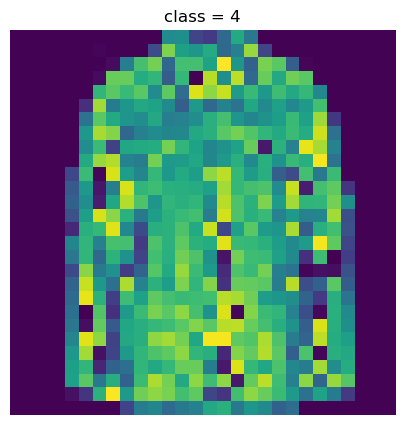

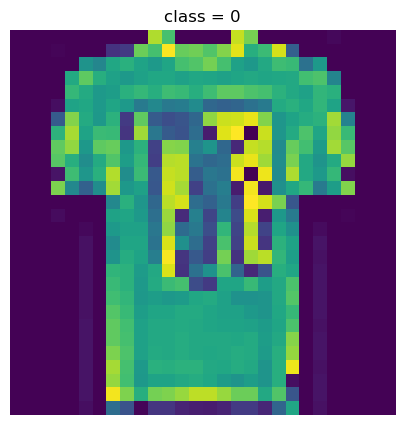

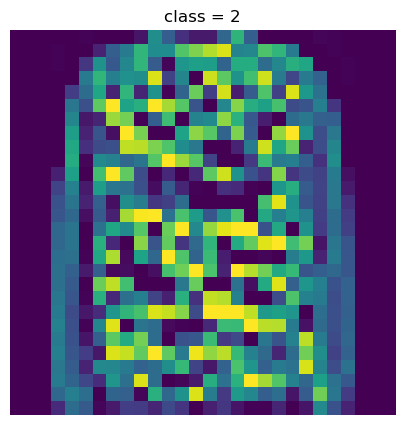

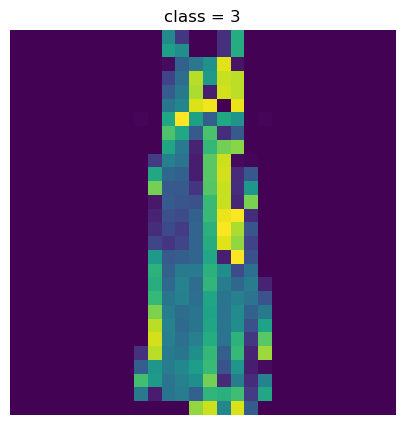

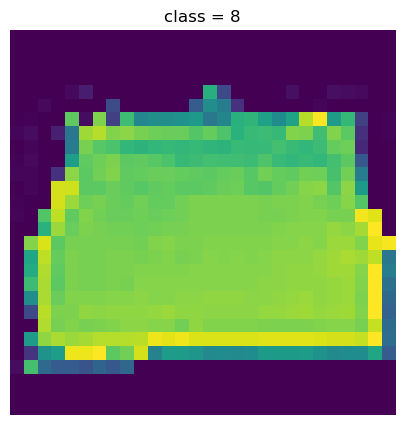

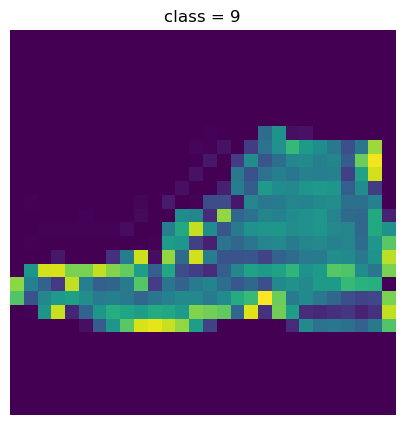

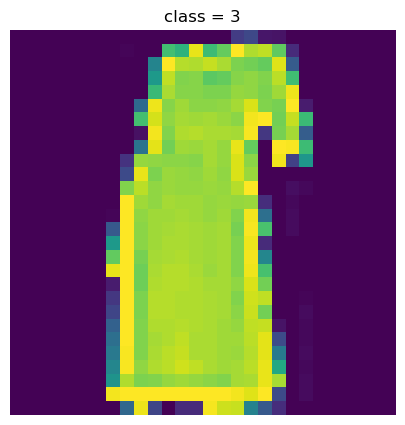

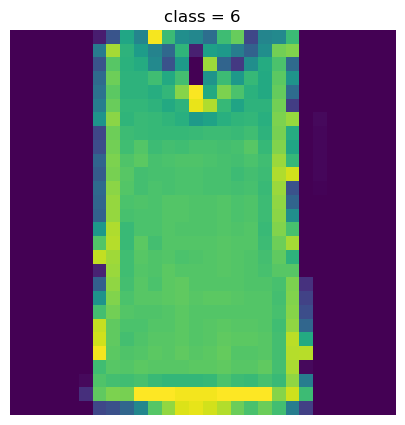

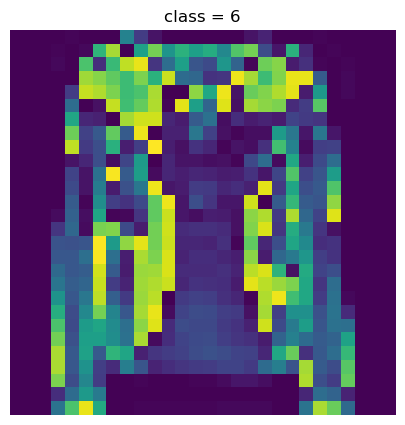

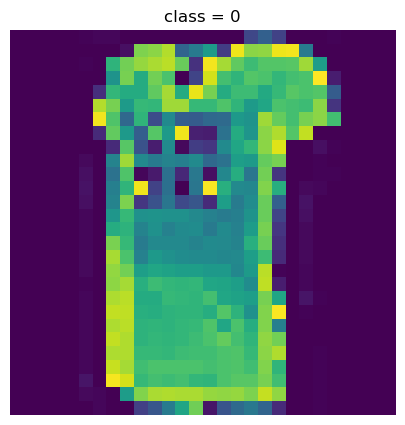

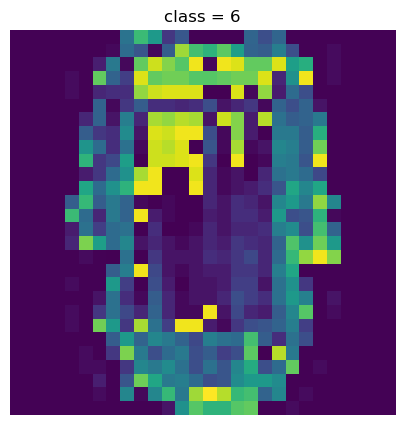

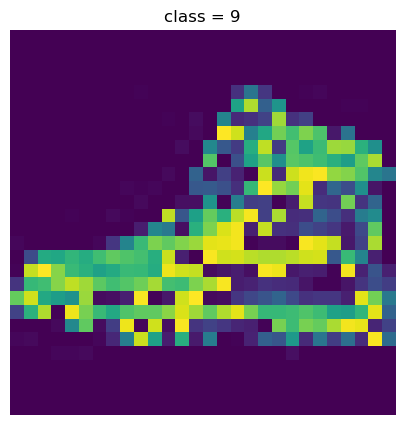

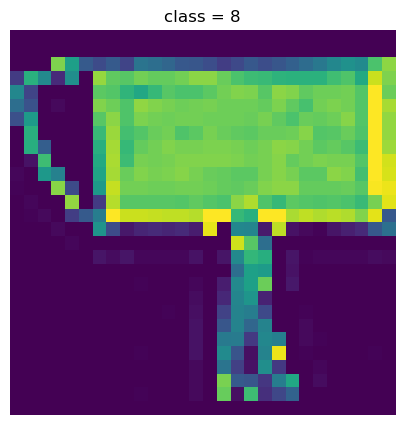

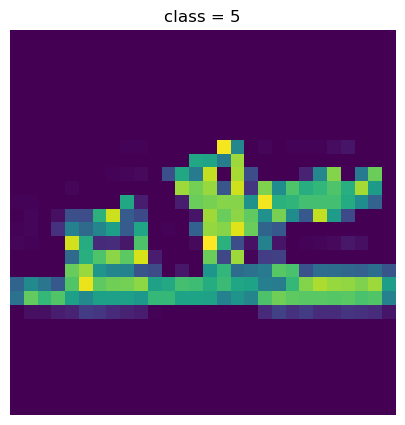

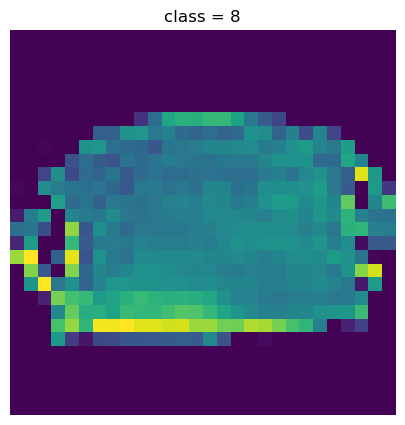

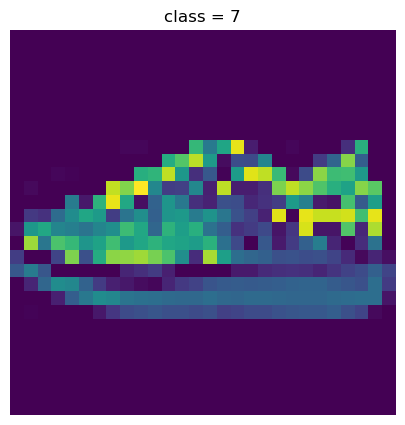

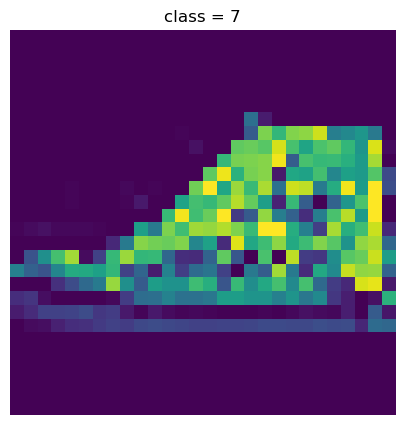

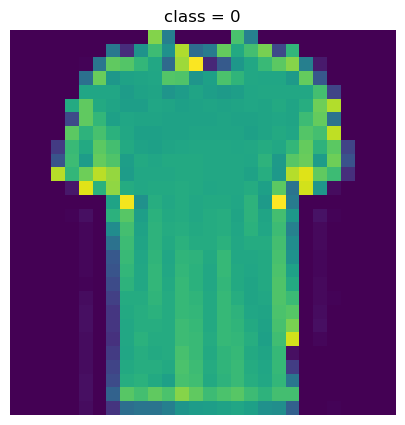

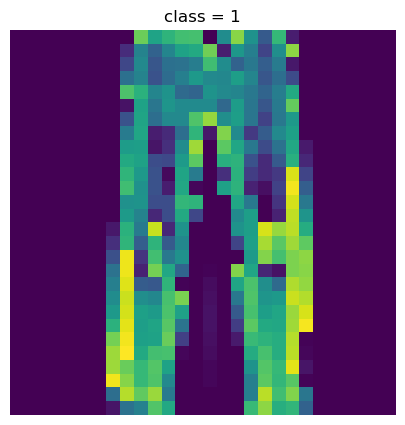

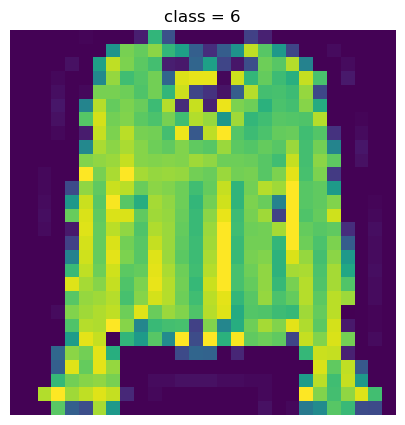

In [10]:
# --- TEST ---
for i, (imgs, labels) in enumerate(dataloader):
    for img, l in zip(imgs, labels):
        show_image(img, label=f'class = {l}')
        #print(img.shape)
    if i > 5: break


In [9]:
# Module to print intermediate results
class Printer(nn.Module):
    def __init__(self, get_to_print_func) -> None:
        super(Printer, self).__init__()
        self.get_to_print_func = get_to_print_func

    def forward(self, inp):
        print(self.get_to_print_func(inp))
        return inp

In [10]:
def init_weights(model):
    #classname = m.__class__.__name__

    if isinstance(model, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(model.weight.data, mean=0.0, std=0.02)
        # according to original paper the weights of the gen and disc
        # should be randomly initialized from normal distribution with
        # mean = 0.0 and std=0.02

In [11]:
'''
both the generator and discriminator are designed as CNNs, the discriminator applies downsampling to the genrated/real image
it receives as input to determine its probability of being real or fake. 
The generator on the other hand applies upsampling (deconvolution) to the sample latent vector it receives as input. The latent vector is sampled
from an normal distribution.
For the generator and discriminator we use architectures that are very similar to the ones presented in the lecture.
The architecture tweaks are inspired from a youtube tutorial on DCGANS.
'''


class Generator(nn.Module):
    def __init__(self, z_size, img_channels, gen_features = 64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(

            #upsampling (deconv)
            self._block(z_size, gen_features * 16, 2, 1, 0),
            # 100 -> 64 x 16 x (4 x 4) = 1024 x (4 x 4)
            self._block(gen_features*16, gen_features * 8, 2, 1, 0),
            self._block(gen_features*8, gen_features*4, 4, 2, 1),
            self._block(gen_features*4, gen_features * 2, 2, 1, 0),
            self._block(gen_features*2, gen_features * 1, 4, 2, 1),
            #transpose to batch_size, number of features and number of channels, in this case 32 * 64 * 64 * 1 
            nn.ConvTranspose2d(gen_features*1, img_channels, kernel_size=4, stride=2, padding=1),
          #  Printer(lambda x: f'last block shape: {x.shape}'),
            nn.Tanh()
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, inp):
        return self.main(inp)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, disc_features=64):
        super(Discriminator, self).__init__()
        
        #downsampling
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, disc_features, 4, 2, 1),
            nn.LeakyReLU(),
            self._block(disc_features, disc_features*2, 4, 2, 1),
            #Printer(lambda x: f'{x.shape}'),
            self._block(disc_features*2, disc_features*4, 4, 2, 1),
            #Printer(lambda x: f'{x.shape}'),
            nn.Conv2d(disc_features*4, 1, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward (self, inp):
        return self.main(inp)


In [13]:
z_dim = 100 # input noise vector
G = Generator(z_dim,1)

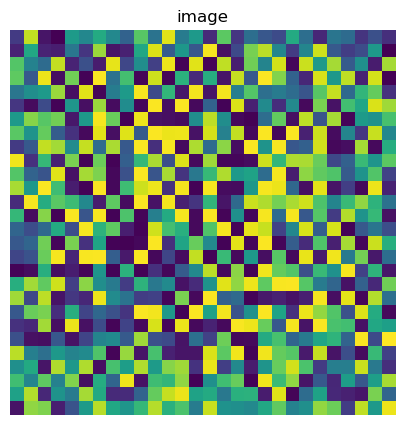

In [14]:
# generator test
z = torch.randn(batch_size, z_dim, 1, 1)
imgs = G(z)
show_image(imgs[0])


In [15]:
from torch.utils.tensorboard import SummaryWriter

In [16]:
writer_real = SummaryWriter("runs/real")
writer_fake = SummaryWriter("runs/fake")
writer_loss = SummaryWriter("runs/loss")

In [17]:
batch_size = 32
num_epochs = 6
learning_rate = 0.0002
input_dim = 100
label_dim = 10
image_dim = 1
z_size = 100

In [56]:
fixed_noise = torch.randn(batch_size, input_dim, 1, 1).to(device)

gen = Generator(z_size, image_dim).to(device)
disc = Discriminator(image_dim).to(device)

init_weights(gen)
init_weights(disc)

optimizer_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.BCELoss()

step = 0

gen.train()
disc.train()


for epoch in range(num_epochs):
    for iteration, (real, _) in enumerate(tqdm(dataloader)): #a wise GAN once said: "Who needs labels!!"
        
        real = real.to(device)
        noise = torch.randn(batch_size, input_dim, 1, 1).to(device)
        fake = gen(noise)

        # Train Discriminator 
        #train with real batch
        #real_labels = labels.to(device)
        
        #discriminator is evaluated for its ability to distinguish real images from fake, real image are given probability 
        #close to 1 and fake images a probability close to 0, so loss_disc_real is computed against a vector containing
        # batch_size of ones, and loss_disc_fake is computed against a vector containing batch_size of zeros
        # the total loss is then take as the mean of both
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2 #get mean of losses
        disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()


        #train with fake batch
        #generator loss is equivalent to the inability of the discriminator to classify fake images as fake
        #the generator has a low loss if the discriminator classifies a lot of fake images as real. Hence generator loss
        #is computed against of a vector containing batch_size of ones
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()  

        writer_loss.add_scalar('Discriminator Loss', loss_disc, epoch * len(dataloader) + iteration)
        writer_loss.add_scalar('Generator Loss', loss_gen, epoch * len(dataloader) + iteration)


        #if iteration % 100 == 0:
    #loss of last iteration of each epoch
    print(f"Epoch [{epoch}/{num_epochs}] Batch {iteration}/{len(dataloader)} \Loss D: {loss_disc}, loss G: {loss_gen}")     

    # Save real images

    #torchvision.utils.save_image(real, f"real_images_{epoch}.png", normalize=True)
    # Save sampled images
    #torchvision.utils.save_image(fake, f"fake_images_{epoch}.png", normalize=True)
    
    with torch.no_grad():
        fake = gen(fixed_noise)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real, normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1

    # Save models after each epoch
    torch.save(disc.state_dict(), f'discriminator_model_epoch_{epoch}.pt')
    torch.save(gen.state_dict(), f'generator_model_epoch_{epoch}.pt')
    #writer.add_images('Generated Images', fake_imgs, epoch)

writer_real.flush()
writer_fake.flush()

100%|██████████| 1875/1875 [00:59<00:00, 31.72it/s]


Epoch [0/6] Batch 1874/1875 \Loss D: 0.21056576073169708, loss G: 3.0298051834106445


100%|██████████| 1875/1875 [01:01<00:00, 30.44it/s]


Epoch [1/6] Batch 1874/1875 \Loss D: 0.13815046846866608, loss G: 3.899052619934082


100%|██████████| 1875/1875 [01:00<00:00, 30.99it/s]


Epoch [2/6] Batch 1874/1875 \Loss D: 0.24561592936515808, loss G: 3.7363455295562744


100%|██████████| 1875/1875 [01:00<00:00, 30.91it/s]


Epoch [3/6] Batch 1874/1875 \Loss D: 0.050868064165115356, loss G: 3.8204803466796875


100%|██████████| 1875/1875 [01:07<00:00, 27.92it/s]


Epoch [4/6] Batch 1874/1875 \Loss D: 0.07442877441644669, loss G: 4.067539215087891


100%|██████████| 1875/1875 [01:09<00:00, 26.94it/s]


Epoch [5/6] Batch 1874/1875 \Loss D: 0.14900967478752136, loss G: 2.8279309272766113


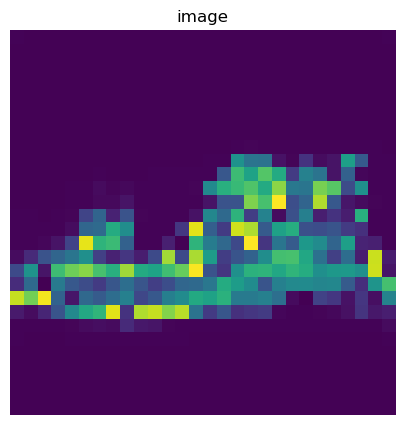

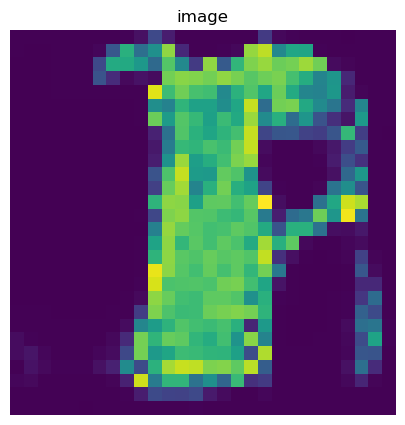

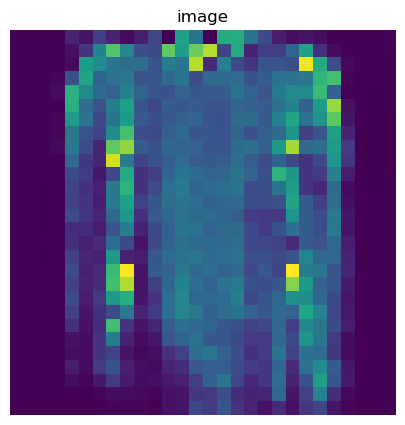

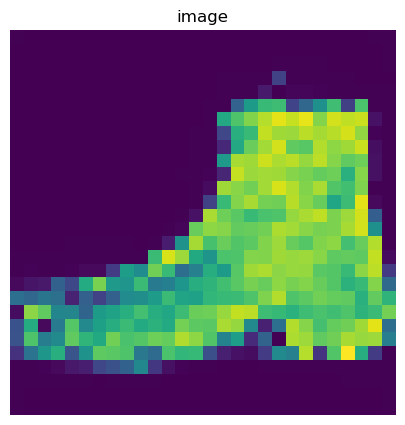

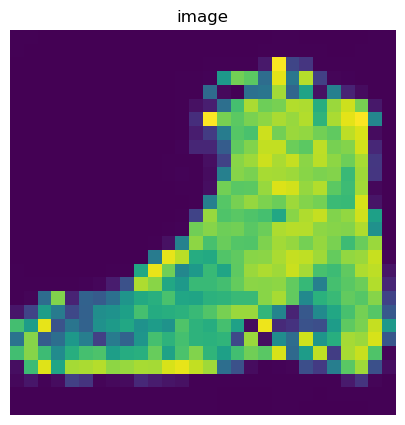

In [19]:
#load generator model
model = Generator(z_size, image_dim).to(device)
model.load_state_dict(torch.load("generator_model_epoch_5.pt"))
model.eval()  # Set the generator to evaluation mode

#show some generated pics
with torch.no_grad():
    for i in range(5):  # Print 5 generated images
        z = torch.randn(1, input_dim, 1, 1).to(device)
        fake_img = model(z).detach().cpu()

        # Plot the generated image
        show_image(fake_img[0])